<a href="https://colab.research.google.com/github/MatiasNazareth1993-coder/Virtual-cell/blob/main/Virtual_Cell_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# telomere_sim.py  (drop into a Jupyter cell)
import numpy as np
import random
from dataclasses import dataclass
from typing import Callable, List

@dataclass
class Cell:
    L: float           # telomere length (units)
    debris: float      # debris load
    age: int           # divisions count
    alive: bool = True
    telomerase_active: bool = False

def step_cell(cell: Cell,
              controller: Callable[[Cell], float],
              params: dict,
              rng: np.random.Generator):
    if not cell.alive:
        return cell
    # decide telomerase activation (0..1)
    act = controller(cell)    # controller returns activation level in [0,1]
    cell.telomerase_active = (act > params['tel_activation_threshold'])

    # cell division decision
    p_div = params['base_division_prob'] * (1.0 - cell.debris / (cell.debris + 1.0))
    if rng.uniform() < p_div:
        # division occurs
        cell.age += 1
        # telomere loss per division (stochastic)
        loss = rng.normal(params['mean_loss'], params['loss_sd'])
        loss = max(0.0, loss)
        cell.L -= loss
        # telomerase action can add back a fraction
        if cell.telomerase_active:
            add = act * params['max_add'] * rng.normal(1.0, params.get('add_sd', 0.0))
            cell.L += max(0.0, add)

    # debris accumulation and phagocytosis
    cell.debris += params['debris_rate']
    # phagocytosis reduces debris proportionally to capacity
    cell.debris = max(0.0, cell.debris - params['phago_capacity'] * act)

    # senescence/cell death checks
    if cell.L < params['critical_length'] or cell.age > params['max_divisions']:
        cell.alive = False

    return cell

# Example naive controllers
def pid_controller_factory(target_L, Kp=0.1):
    def ctrl(cell: Cell):
        err = target_L - cell.L
        # simple proportional
        act = np.clip(Kp * err, 0.0, 1.0)
        return act
    return ctrl

def random_controller(cell: Cell):
    return random.random() * 0.1

# Simulation runner
def run_population(N=100, steps=1000, controller=None, params=None, seed=0):
    rng = np.random.default_rng(seed)
    if params is None:
        params = {
            'mean_loss': 50.0, 'loss_sd': 10.0, 'max_add': 80.0,
            'tel_activation_threshold': 0.05,
            'base_division_prob': 0.05, 'debris_rate': 0.01,
            'phago_capacity': 0.02, 'critical_length': 200.0,
            'max_divisions': 1000
        }
    if controller is None:
        controller = pid_controller_factory(target_L=1000.0, Kp=0.005)

    pop = [Cell(L=rng.normal(800,50), debris=0.0, age=0) for _ in range(N)]
    stats = {'mean_L': [], 'alive_frac': [], 'mean_age': []}

    for t in range(steps):
        for i, c in enumerate(pop):
            pop[i] = step_cell(c, controller, params, rng)
        alive = [c for c in pop if c.alive]
        stats['mean_L'].append(np.mean([c.L for c in alive]) if alive else 0.0)
        stats['alive_frac'].append(len(alive)/N)
        stats['mean_age'].append(np.mean([c.age for c in pop]) if pop else 0.0)
    return stats, pop

# To run:
if __name__ == '__main__':
    stats, pop = run_population()
    print("Final alive fraction:", stats['alive_frac'][-1])


Final alive fraction: 1.0


In [ ]:
# foundation_timeseries.py
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# ---------- Dataset (windowed time-series) ----------
class TimeWindowDataset(Dataset):
    def __init__(self, series_array, window=64, stride=1, augment_fn=None):
        # series_array: numpy array shape (N_series, T_total, F)
        self.series = series_array
        self.window = window
        self.stride = stride
        self.augment_fn = augment_fn
        self.index = []  # list of (series_idx, start)
        for i in range(series_array.shape[0]):
            T = series_array.shape[1]
            for s in range(0, T - window + 1, stride):
                self.index.append((i, s))

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):
        i, s = self.index[idx]
        x = self.series[i, s:s+self.window].astype('float32')  # (W, F)
        if self.augment_fn:
            x = self.augment_fn(x)
        return torch.from_numpy(x)  # (W, F)

# ---------- Positional encoding (relative-friendly) ----------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=10000):
        super().__init__()
        self.d_model = d_model
        # use standard sinusoidal for now
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe.unsqueeze(0))  # (1, max_len, d_model)

    def forward(self, x):
        # x: (B, T, D)
        T = x.shape[1]
        return x + self.pe[:, :T, :]

# ---------- Transformer encoder-based time-series foundation model ----------
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, d_model=128, n_layers=6, n_heads=8, mlp_dim=256, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_enc = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, n_heads, mlp_dim, dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.pool = nn.AdaptiveAvgPool1d(1)  # pool on time
        # small projection head for contrastive/masked objectives
        self.head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, d_model)
        )

    def forward(self, x, mask=None):
        # x: (B, T, F)
        h = self.input_proj(x)                 # (B, T, d)
        h = self.pos_enc(h)                    # (B, T, d)
        if mask is not None:
            # mask is boolean (B, T) where True=mask
            # Replace masked tokens with zeros (or learned mask token)
            h = h.masked_fill(mask.unsqueeze(-1), 0.0)
        h = self.encoder(h)                    # (B, T, d)
        pooled = h.mean(dim=1)                 # simple mean pool (B, d)
        z = self.head(pooled)                  # (B, d)
        return h, z

# ---------- Simple masked reconstruction loss ----------
def masked_mse_loss(recon, target, mask):
    # recon, target: (B, T, F)
    # mask: boolean (B, T) True means masked & should be predicted
    diff = (recon - target)**2
    mask = mask.unsqueeze(-1).expand_as(diff)
    if mask.sum() == 0:
        return torch.tensor(0.0, device=diff.device, requires_grad=True)
    return diff[mask].mean()

# ---------- Example training loop (masked autoencoding style) ----------
def train_one_epoch(model, dataloader, optimizer, device, input_dim, mask_prob=0.15):
    model.train()
    total_loss = 0.0
    for batch in dataloader:
        batch = batch.to(device)  # (B, T, F)
        B, T, F = batch.shape
        # create mask
        mask = (torch.rand(B, T, device=device) < mask_prob)
        optimizer.zero_grad()
        _, z = model(batch, mask=mask)  # get embeddings; masked tokens were zeroed
        # simple decoder: map encoded per-token back to features
        # For simplicity, reuse a small decoder projecting pooled z to window recon
        # Here we try to reconstruct masked features by a simple MLP applied to pooled z
        recon = model.input_proj.weight.new_zeros(B, T, F)  # placeholder decoder (replace with real decoder)
        # naive: broadcast pooled z to all timesteps then project (toy)
        recon = z.unsqueeze(1).repeat(1, T, 1)
        recon = torch.nn.Linear(z.shape[-1], F).to(device)(recon)  # temporary linear decoder
        loss = masked_mse_loss(recon, batch, mask)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * B
    return total_loss / len(dataloader.dataset)

# ---------- Usage example ----------
if __name__ == '__main__':
    import numpy as np
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # toy data: 200 series, length 1000, features 5
    data = np.random.randn(200, 1000, 5).astype('float32')
    ds = TimeWindowDataset(data, window=64, stride=16)
    dl = DataLoader(ds, batch_size=32, shuffle=True, drop_last=True)
    model = TimeSeriesTransformer(input_dim=5, d_model=128, n_layers=4, n_heads=4).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=1e-4)
    for epoch in range(3):
        loss = train_one_epoch(model, dl, opt, device, input_dim=5)
        print(f'epoch {epoch} loss {loss:.6f}')

In [ ]:
%%writefile generate_windows_from_top_designs.py
"""
Generate synthetic time-series trajectories for top-ranked abstract designs
and convert them to sliding windows for downstream training.

Inputs:
  --summary : CSV produced by the large-scale sweep (summary_with_emb.csv or summary.csv)
Outputs (saved in --outdir):
  - windows.npy         : (N_windows, window_len, F) float32
  - metadata.csv        : CSV mapping each window index to design_id, rep_id, t0 and parameters
  - traces/             : per-design per-replicate full time series (optional debug)
Notes:
  - All simulations are abstract numeric models (no DNA sequences).
  - F = number of channels/features per timestep: [telomere_len_norm, telomerase_active, debris, division_flag]
"""

import argparse
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import sys # Import sys

# ---------------------------
# Reuse the abstract simulator (time-series version)
# ---------------------------
def simulate_lineage_timeseries(initial_length=1000.0,
                                stability=0.0,
                                recognition_affinity=0.5,
                                repair_efficiency=0.1,
                                structural_propensity=0.5,
                                base_loss_mean=50.0,
                                base_loss_sd=10.0,
                                max_steps=1000,
                                division_prob=0.05,
                                telomerase_threshold_ratio=0.95,
                                rng=None):
    """
    Simulate one lineage and return time-series arrays:
      telomere_len (T,), telomerase_active_flag (T,), debris (T,), division_flag (T,)
    All numeric and abstract. rng: np.random.Generator for reproducibility.
    """
    if rng is None:
        rng = np.random.default_rng()

    L = initial_length
    telomerase_active = 0
    debris = 0.0

    tel_series = []
    act_series = []
    debris_series = []
    div_flag_series = []

    target = initial_length * telomerase_threshold_ratio

    for t in range(max_steps):
        # small random repair events
        if rng.random() < repair_efficiency:
            L += rng.uniform(0.5, 2.0) * repair_efficiency

        division = 0
        # decide division
        if rng.random() < division_prob:
            division = 1
            loss = max(0.0, rng.normal(base_loss_mean * (1.0 - 0.2*structural_propensity),
                                       base_loss_sd))
            loss *= (1.0 - stability)
            L -= loss

            if L < target:
                engage_prob = recognition_affinity * (0.5 + 0.5 * structural_propensity)
                if rng.random() < engage_prob:
                    add = recognition_affinity * (50.0 + 50.0 * structural_propensity)
                    L += add
                    telomerase_active = 1
                else:
                    telomerase_active = 0
            else:
                telomerase_active = 0

        # debris dynamics: activation increases metabolic load → small debris production
        debris += telomerase_active * 0.02 + 0.005  # baseline slow accumulation
        # clearance roughly proportional to repair_efficiency and structural_propensity
        debris -= 0.01 * (repair_efficiency + 0.5*structural_propensity)
        debris = max(0.0, debris)

        # occasional small stochastic damage
        if rng.random() < 0.001 + 0.01*(1.0 - structural_propensity):
            L -= rng.uniform(0.5, 3.0)

        # clamp L to non-negative and a practical max
        L = max(0.0, min(2000.0, L))

        tel_series.append(L)
        act_series.append(float(telomerase_active))
        debris_series.append(float(debris))
        div_flag_series.append(int(division))

    # return numpy arrays
    return (np.array(tel_series, dtype=np.float32),
            np.array(act_series, dtype=np.float32),
            np.array(debris_series, dtype=np.float32),
            np.array(div_flag_series, dtype=np.float32))


# ---------------------------
# Windowing utility
# ---------------------------
def make_windows_from_trace(trace_arrays, window=128, stride=32):
    """
    trace_arrays: list/tuple of arrays (T,) each same length
    returns stacked windows shape (N_windows, window, F)
    """
    T = trace_arrays[0].shape[0]
    if any(arr.shape[0] != T for arr in trace_arrays):
        raise ValueError("All trace arrays must have same length")
    if T < window:
        # pad ends by repeating final value
        padded = [np.pad(a, (0, window - T), mode='edge') for a in trace_arrays]
        trace_arrays = padded
        T = window

    windows = []
    for s in range(0, T - window + 1, stride):
        w = np.stack([arr[s:s+window] for arr in trace_arrays], axis=-1)  # (window, F)
        windows.append(w.astype(np.float32))
    if len(windows) == 0:
        return np.zeros((0, window, len(trace_arrays)), dtype=np.float32)
    return np.stack(windows, axis=0)


# ---------------------------
# Top-design selector
# ---------------------------
def select_top_designs(summary_df, n_top=100, min_quality=None, sort_by="mean_final_L"):
    """
    summary_df: DataFrame with design parameter columns: stability, recognition_affinity, repair_efficiency, structural_propensity
                and metric columns like mean_final_L, frac_senesced
    n_top: number of designs to return
    min_quality: tuple (metric_name, max_allowed) to filter (e.g., ("frac_senesced", 0.2))
    """
    df = summary_df.copy()
    if min_quality is not None:
        metric, max_allowed = min_quality
        df = df[df[metric] <= max_allowed]
    df_sorted = df.sort_values(by=sort_by, ascending=False)
    return df_sorted.head(n_top).reset_index(drop=True)


# ---------------------------
# Main orchestration
# ---------------------------
def generate_windows_for_top_designs(summary_csv,
                                     n_top=100,
                                     reps_per_design=50,
                                     outdir="generated_windows",
                                     window=128,
                                     stride=32,
                                     max_steps=1000,
                                     seed=0,
                                     min_frac_senesced=0.25):
    outdir = Path(outdir)
    outdir.mkdir(parents=True, exist_ok=True)
    traces_dir = outdir / "traces"
    traces_dir.mkdir(exist_ok=True)

    # load summary
    df = pd.read_csv(summary_csv)
    required_cols = {"stability","recognition_affinity","repair_efficiency","structural_propensity"}
    if not required_cols.issubset(set(df.columns)):
        raise RuntimeError(f"summary csv must contain columns: {required_cols}")

    # select top designs (filter by frac_senesced threshold to avoid designs that are too senescing)
    top_df = select_top_designs(df, n_top=n_top, min_quality=("frac_senesced", min_frac_senesced), sort_by="mean_final_L")

    windows_all = []
    metadata_rows = []

    rng_master = np.random.default_rng(seed)
    design_counter = 0

    print(f"[generate] generating windows for {len(top_df)} designs (reps={reps_per_design})")
    for idx, row in tqdm(top_df.iterrows(), total=len(top_df)):
        design_id = f"design_{design_counter:05d}"
        design_counter += 1
        params = {
            "stability": float(row["stability"]),
            "recognition_affinity": float(row["recognition_affinity"]),
            "repair_efficiency": float(row["repair_efficiency"]),
            "structural_propensity": float(row["structural_propensity"])
        }
        # for reproducibility, seed per design
        seed_base = int(rng_master.integers(0, 2**31-1))
        for rep in range(reps_per_design):
            rng = np.random.default_rng(seed_base + rep)
            tel, act, debris, divflag = simulate_lineage_timeseries(
                initial_length=1000.0,
                stability=params["stability"],
                recognition_affinity=params["recognition_affinity"],
                repair_efficiency=params["repair_efficiency"],
                structural_propensity=params["structural_propensity"],
                max_steps=max_steps,
                division_prob=0.05,
                rng=rng
            )
            # normalize telomere length to a convenient scale (e.g., divide by 1000)
            tel_norm = tel / 1000.0

            # build feature channels: [tel_norm, act, debris, divflag]
            trace_arrays = [tel_norm, act, debris, divflag]

            # save full trace for debugging
            trace_path = traces_dir / f"{design_id}_rep{rep:03d}.npz"
            np.savez_compressed(trace_path,
                                tel=tel, tel_norm=tel_norm,
                                act=act, debris=debris, divflag=divflag,
                                **params)
            # produce sliding windows
            win = make_windows_from_trace(trace_arrays, window=window, stride=stride)  # (Nw, window, F)
            if win.shape[0] == 0:
                continue
            start_idx = len(windows_all)
            windows_all.append(win)
            # build metadata for each produced window
            for w_i in range(win.shape[0]):
                metadata_rows.append({
                    "window_index": start_idx + w_i,
                    "design_id": design_id,
                    "source_row_index": int(idx),
                    "replicate": rep,
                    "t0": int(w_i * stride),
                    "stability": params["stability"],
                    "recognition_affinity": params["recognition_affinity"],
                    "repair_efficiency": params["repair_efficiency"],
                    "structural_propensity": params["structural_propensity"]
                })

    # concatenate all windows
    if len(windows_all) == 0:
        raise RuntimeError("No windows generated — adjust parameters (increase reps, decrease window length, etc.)")
    windows_array = np.concatenate(windows_all, axis=0)
    windows_path = outdir / f"windows_w{window}_s{stride}.npy"
    np.save(windows_path, windows_array.astype(np.float32))
    print(f"[saved] windows → {windows_path} shape={windows_array.shape}")

    # save metadata
    meta_df = pd.DataFrame(metadata_rows)
    meta_path = outdir / "metadata.csv"
    meta_df.to_csv(meta_path, index=False)
    print(f"[saved] metadata → {meta_path} rows={len(meta_df)}")

    # Save summary of selected designs for traceability
    top_df.reset_index(drop=True).to_csv(outdir / "selected_designs.csv", index=False)
    print(f"[saved] selected design table → {outdir/'selected_designs.csv'}")

    return windows_path, meta_path, traces_dir


# ---------------------------
# CLI
# ---------------------------
if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--summary", type=str, required=True, help="Path to summary_with_emb.csv or summary.csv from sweep")
    parser.add_argument("--n_top", type=int, default=100, help="How many top designs to use")
    parser.add_argument("--reps_per_design", type=int, default=50, help="Stochastic replicates per design")
    parser.add_argument("--outdir", type=str, default="generated_windows", help="Output dir")
    parser.add_argument("--window", type=int, default=128, help="Window length for produced windows")
    parser.add_argument("--stride", type=int, default=32, help="Window stride")
    parser.add_argument("--max_steps", type=int, default=1000, help="Length of simulated trace (timesteps)")
    parser.add_argument("--seed", type=int, default=0)
    parser.add_argument("--min_frac_senesced", type=float, default=0.25, help="Only select designs with frac_senesced <= this")

    # Handle Colab's internal arguments and provide a default for --summary
    if '-f' in sys.argv or len(sys.argv) == 1:
        # When running in Jupyter/Colab, parse an empty list of arguments
        args = parser.parse_args(['--summary', './results/summary.csv'])
    else:
        # Otherwise, parse arguments normally (e.g., when run from command line)
        args = parser.parse_args(sys.argv[1:])

    windows_path, meta_path, traces_dir = generate_windows_for_top_designs(
        summary_csv=args.summary,
        n_top=args.n_top,
        reps_per_design=args.reps_per_design,
        outdir=args.outdir,
        window=args.window,
        stride=args.stride,
        max_steps=args.max_steps,
        seed=args.seed,
        min_frac_senesced=args.min_frac_senesced
    )

    print("Done. Generated windows and metadata.")

Writing generate_windows_from_top_designs.py


In [ ]:
import json

deepspeed_config_str = '''
{
  "train_batch_size": 1024,
  "train_micro_batch_size_per_gpu": 8,
  "gradient_accumulation_steps": 16,
  "steps_per_print": 100,
  "optimizer": {
    "type": "AdamW",
    "params": {
      "lr": 1e-4,
      "betas": [0.9, 0.95],
      "eps": 1e-8,
      "weight_decay": 0.01
    }
  },
  "scheduler": {
    "type": "WarmupLR",
    "params": {
      "warmup_min_lr": 0,
      "warmup_max_lr": 1e-4,
      "warmup_num_steps": 10000
    }
  },
  "fp16": {
    "enabled": true,
    "initial_scale_power": 16
  },
  "zero_optimization": {
    "stage": 3,
    "offload_param": {
      "device": "cpu",
      "pin_memory": true
    },
    "offload_optimizer": {
      "device": "cpu",
      "pin_memory": true
    },
    "overlap_comm": true,
    "contiguous_gradients": true,
    "sub_group_size": 1e9
  },
  "activation_checkpointing": {
    "partition_activations": true,
    "contiguous_memory_optimization": true
  },
  "gradient_clipping": 1.0,
  "wall_clock_breakdown": false
}
'''

deepspeed_config = json.loads(deepspeed_config_str)

# Save the DeepSpeed configuration to a JSON file
with open('deepspeed_config.json', 'w') as f:
    json.dump(deepspeed_config, f, indent=2)

print("DeepSpeed configuration saved to deepspeed_config.json")

# You can now use deepspeed_config as a Python dictionary.
# For example, to print it:
# print(deepspeed_config)


DeepSpeed configuration saved to deepspeed_config.json


In [ ]:
!pip install deepspeed

# NOTE: You will need to replace '/path/to/windows' with an actual .npy data file
# and '/path/to/checkpoints' with your desired output directory.
!deepspeed --num_gpus=8 /content/train.py \
  --config_path /content/deepspeed_config.json \
  --model_config configs/model_large.json \
  --data-path /path/to/your_data.npy \
  --output-dir /path/to/checkpoints

[2025-11-18 07:13:17,626] [WARNING] [real_accelerator.py:209:get_accelerator] Setting accelerator to CPU. If you have GPU or other accelerator, we were unable to detect it.
2025-11-18 07:13:31.482235: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763450011.538509   36305 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763450011.555648   36305 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763450011.598398   36305 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763450011.598491   36305 computation_placer.cc:177] computation placer alrea

In [ ]:
# Create the configs directory
!mkdir -p configs
print("Created 'configs' directory.")

Created 'configs' directory.


In [ ]:
import json
import numpy as np

# Define content for model_large.json
model_config_content = {
    "input_dim": 5,  # Assuming dummy_data will have 5 features
    "d_model": 256,
    "n_heads": 8,
    "n_layers": 6,
    "mlp_dim": 512,
    "cnn_channels": 256,
    "kernel_size": 5
}

# Save model_large.json
with open('configs/model_large.json', 'w') as f:
    json.dump(model_config_content, f, indent=2)
print("Created 'configs/model_large.json'.")

Created 'configs/model_large.json'.


In [ ]:
# Create a dummy .npy data file
dummy_data = np.random.randn(100, 128, 5).astype('float32') # 100 windows, 128 length, 5 features
np.save('dummy_data.npy', dummy_data)
print(f"Created 'dummy_data.npy' with shape {dummy_data.shape}.")

Created 'dummy_data.npy' with shape (100, 128, 5).


In [ ]:
!pip install deepspeed

# NOTE: /path/to/your_data.npy and configs/model_large.json have been generated in previous cells.
# Replacing placeholders with paths to generated dummy files.
!deepspeed --num_gpus=8 /content/train.py \
  --config_path /content/deepspeed_config.json \
  --model_config /content/configs/model_large.json \
  --data-path /content/dummy_data.npy \
  --output-dir /content/checkpoints_output

[2025-11-18 07:20:11,059] [WARNING] [real_accelerator.py:209:get_accelerator] Setting accelerator to CPU. If you have GPU or other accelerator, we were unable to detect it.
2025-11-18 07:20:32.268907: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763450432.545860   38199 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763450432.622557   38199 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763450433.206402   38199 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763450433.206455   38199 computation_placer.cc:177] computation placer alrea

In [ ]:
# Create the configs directory
!mkdir -p configs
print("Created 'configs' directory.")

Created 'configs' directory.


In [ ]:
lr_start = 5e-4      # 5× higher
lr_peak  = 8e-4      # plateau peak
warmup_steps = 20000   # slower warmup for stability
plateau_steps = 50000  # hold high lr to learn rare events

In [ ]:
import torch.nn as nn

class MySimpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(10, 1)

    def forward(self, x):
        return self.linear(x)

model = MySimpleModel()
# Now model is defined, and you can call:
torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

tensor(0.)

In [ ]:
import torch
torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

tensor(0.)

In [ ]:
%%writefile train.py
"""
Train script for TimeSeries Foundation Model (Transformer encoder + CNN decoder)
with masked reconstruction + contrastive loss and an aggressive LR schedule.

Usage examples:
  # With DeepSpeed (recommended)
  deepspeed --num_gpus=8 train.py --data-path /path/to/shards --output-dir /path/to/out \
            --batch-size 32 --epochs 10 --window 128

  # Without DeepSpeed (single-GPU)
  python train.py --data-path ./toy.npy --output-dir ./out --batch-size 32 --epochs 3
"""

import os
import math
import argparse
import time
import json
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

# Try to import deepspeed; if not available we'll use plain PyTorch training
try:
    import deepspeed
    DEEPSPEED_AVAILABLE = True
except Exception:
    DEEPSPEED_AVAILABLE = False

# ---------------------------
# Dataset: windowed time-series
# ---------------------------
class TimeWindowDataset(Dataset):
    def __init__(self, series_array, window=128, stride=32, augment_fn=None):
        """
        series_array: np.array shape (N_series, T_total, F)
        If series_array is a path to a .npy file, it will be loaded.
        """
        if isinstance(series_array, str):
            self.data = np.load(series_array)
        else:
            self.data = series_array
        self.window = window
        self.stride = stride
        self.augment_fn = augment_fn
        self.index = []
        for i in range(self.data.shape[0]):
            T = self.data.shape[1]
            for s in range(0, T - window + 1, stride):
                self.index.append((i, s))

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):
        i, s = self.index[idx]
        x = self.data[i, s:s+self.window].astype('float32')
        if self.augment_fn:
            x = self.augment_fn(x)
        return torch.from_numpy(x)  # (T, F)


# ---------------------------
# Positional Encoding
# ---------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=10000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe.unsqueeze(0))

    def forward(self, x):
        # x: (B, T, D)
        T = x.size(1)
        return x + self.pe[:, :T]


# ---------------------------
# Model: Transformer encoder + CNN decoder + projection head
# ---------------------------
class TimeSeriesFoundationModel(nn.Module):
    def __init__(self, input_dim, d_model=256, n_heads=8, n_layers=6, mlp_dim=512,
                 cnn_channels=256, kernel_size=5):
        super().__init__()
        self.input_dim = input_dim
        self.proj = nn.Linear(input_dim, d_model)
        self.pos_enc = PositionalEncoding(d_model)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=mlp_dim,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=n_layers)

        # CNN decoder: (B, d_model, T) -> (B, input_dim, T)
        self.decoder = nn.Sequential(
            nn.Conv1d(d_model, cnn_channels, kernel_size, padding=kernel_size//2),
            nn.ReLU(),
            nn.Conv1d(cnn_channels, cnn_channels, kernel_size, padding=kernel_size//2),
            nn.ReLU(),
            nn.Conv1d(cnn_channels, input_dim, 1)
        )

        # projection head for contrastive learning
        self.project = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Linear(d_model, d_model)
        )

        # mask embedding
        self.mask_embed = nn.Parameter(torch.zeros(1, 1, d_model))

    def forward(self, x, mask=None):
        """
        x: (B, T, F)
        mask: boolean tensor (B, T) where True indicates masked timesteps
        returns: recon (B,T,F), z (B,d), hidden (B,T,d)
        """
        h = self.proj(x)  # (B,T,d)
        if mask is not None:
            # where mask True -> replace projected input by mask embedding
            h = torch.where(mask.unsqueeze(-1), self.mask_embed.expand_as(h), h)
        h = self.pos_enc(h)
        h = self.encoder(h)  # (B,T,d)
        # recon via CNN decoder
        h_c = h.transpose(1, 2)  # (B,d,T)
        recon = self.decoder(h_c).transpose(1, 2)  # (B,T,F)
        pooled = h.mean(dim=1)  # (B,d)
        z = self.project(pooled)
        return recon, z, h


# ---------------------------
# Losses
# ---------------------------
def masked_mse_loss(recon, target, mask):
    mask_exp = mask.unsqueeze(-1).expand_as(target)
    diff = (recon - target)**2
    if mask_exp.sum() == 0:
        return torch.tensor(0.0, device=recon.device)
    return diff[mask_exp].mean()

def contrastive_loss(z1, z2, temperature=0.1):
    z1 = F.normalize(z1, dim=-1)
    z2 = F.normalize(z2, dim=-1)
    logits = (z1 @ z2.t()) / temperature
    labels = torch.arange(z1.size(0), device=z1.device)
    return F.cross_entropy(logits, labels)


# ---------------------------
# LR schedule: warmup -> plateau -> cosine decay to min_lr
# ---------------------------
def make_lr_lambda(steps_warmup, steps_plateau, total_steps, min_lr_ratio=1e-3):
    peak_total = steps_warmup + steps_plateau
    def lr_lambda(step):
        if step < 0:
            return 0.0
        if step < steps_warmup:
            return float(step) / float(max(1, steps_warmup))
        elif step < peak_total:
            return 1.0
        else:
            # cosine decay from 1.0 -> min_lr_ratio over remaining steps
            rem = step - peak_total
            denom = max(1, total_steps - peak_total)
            cosine = 0.5 * (1.0 + math.cos(math.pi * rem / denom))
            return max(min_lr_ratio, cosine * (1.0 - min_lr_ratio) + min_lr_ratio)
    return lr_lambda


# ---------------------------
# Utilities
# ---------------------------
def save_checkpoint(state, out_dir, step):
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    path = out_dir / f"checkpoint_step{step}.pth"
    torch.save(state, path)
    return str(path)


# ---------------------------
# Training loop
# ---------------------------
def train(args):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    writer = SummaryWriter(log_dir=args.output_dir) if args.tensorboard else None

    # Load data
    # If data_path is a .npy file (toy), else assume user provides pre-sharded dataset loading
    if args.data_path.endswith(".npy"):
        data = np.load(args.data_path)
        dataset = TimeWindowDataset(data, window=args.window, stride=args.stride)
    else:
        # For simplicity: expect .npy; users can replace TimeWindowDataset with WebDataset pipeline
        raise RuntimeError("This script expects a .npy dataset for quick runs. Convert your windows to a numpy array first.")

    dataloader = DataLoader(dataset,
                            batch_size=args.batch_size,
                            shuffle=True,
                            num_workers=args.num_workers,
                            drop_last=True)

    # Build model
    example_item = dataset[0]  # (T,F)
    Fdim = example_item.shape[1]
    model = TimeSeriesFoundationModel(
        input_dim=Fdim,
        d_model=args.d_model,
        n_heads=args.n_heads,
        n_layers=args.n_layers,
        mlp_dim=args.mlp_dim,
        cnn_channels=args.cnn_channels,
        kernel_size=args.kernel_size
    )

    # Prepare optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr_peak, betas=(0.9, 0.95), eps=1e-8, weight_decay=args.weight_decay)

    # Learning-rate lambda: warmup -> plateau -> cosine decay
    total_steps = int(len(dataloader) * args.epochs)
    lr_lambda = make_lr_lambda(args.warmup_steps, args.plateau_steps, total_steps, min_lr_ratio=args.min_lr_ratio)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

    # DeepSpeed init if available and requested
    model_engine = None
    if args.use_deepspeed and DEEPSPEED_AVAILABLE:
        # Minimal DeepSpeed config if not provided
        if args.deepspeed_config and os.path.exists(args.deepspeed_config):
            ds_config = args.deepspeed_config
        else:
            # Create a simple config dict (we still pass to initialize)
            ds_conf = {
                "train_batch_size": max(1, args.batch_size * 1),
                "train_micro_batch_size_per_gpu": max(1, args.batch_size),
                "optimizer": {
                    "type": "AdamW",
                    "params": {
                        "lr": args.lr_peak,
                        "betas": [0.9, 0.95],
                        "eps": 1e-8,
                        "weight_decay": args.weight_decay
                    }
                },
                "fp16": {"enabled": True},
                "gradient_clipping": args.grad_clip
            }
            args.deepspeed_config = "tmp_deepspeed_config.json"
            with open(args.deepspeed_config, "w") as f:
                json.dump(ds_conf, f)

        model_parameters = filter(lambda p: p.requires_grad, model.parameters())
        model_engine, optimizer, _, _ = deepspeed.initialize(
            config_params=args.deepspeed_config,
            model=model,
            model_parameters=model_parameters,
            optimizer=optimizer
        )
        print("Initialized DeepSpeed engine.")
    else:
        model.to(device)
        scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

    # loss weights
    recon_weight = args.recon_weight
    contrastive_weight = args.contrastive_weight

    global_step = 0
    start_time = time.time()

    for epoch in range(args.epochs):
        model.train()
        epoch_loss = 0.0
        for batch in dataloader:
            batch = batch.to(device) if model_engine is None else batch.cuda()
            B, T, F = batch.shape

            # ---- create mask for masked reconstruction ----
            mask = (torch.rand(B, T, device=batch.device) < args.mask_prob)

            # ---- create jittered view for contrastive ----
            jitter = batch + args.jitter_scale * torch.randn_like(batch)

            # ---- forward + losses ----
            if model_engine is not None:
                # DeepSpeed-managed forward/backward
                recon, z_masked, _ = model_engine(batch, mask=mask)
                _, z_aug, _ = model_engine(jitter, mask=None)
                L_rec = masked_mse_loss(recon, batch, mask)
                L_con = contrastive_loss(z_masked, z_aug, temperature=args.temperature)
                loss = recon_weight * L_rec + contrastive_weight * L_con
                model_engine.backward(loss)
                model_engine.step()
                # Scheduler step: DeepSpeed may manage scheduler externally; do local step
                # If DeepSpeed returns a scheduler bound to engine, it's fine to call scheduler.step()
                try:
                    scheduler.step()
                except Exception:
                    pass
            else:
                optimizer.zero_grad()
                with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
                    recon, z_masked, _ = model(batch, mask=mask)
                    _, z_aug, _ = model(jitter, mask=None)
                    L_rec = masked_mse_loss(recon, batch, mask)
                    L_con = contrastive_loss(z_masked, z_aug, temperature=args.temperature)
                    loss = recon_weight * L_rec + contrastive_weight * L_con

                scaler.scale(loss).backward()
                # gradient clipping (unscale then clip)
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), args.grad_clip)
                scaler.step(optimizer)
                scaler.update()
                scheduler.step()

            epoch_loss += loss.item()
            global_step += 1

            # Logging
            if writer and (global_step % args.log_interval == 0):
                writer.add_scalar("train/loss", loss.item(), global_step)
                writer.add_scalar("train/recon_loss", L_rec.item(), global_step)
                writer.add_scalar("train/contrastive_loss", L_con.item(), global_step)
                # capture LR
                current_lr = optimizer.param_groups[0]["lr"] if model_engine is None else (optimizer.param_groups[0]["lr"] if isinstance(optimizer, torch.optim.Optimizer) else args.lr_peak)
                writer.add_scalar("train/lr", current_lr, global_step)

            # Checkpointing
            if (global_step % args.checkpoint_interval == 0) and (global_step > 0):
                ckpt_name = f"ckpt_step{global_step}.pth"
                save_path = Path(args.output_dir) / ckpt_name
                if model_engine is not None:
                    model_engine.save_checkpoint(str(args.output_dir), tag=f"step{global_step}")
                    print(f"DeepSpeed saved checkpoint at step {global_step}")
                else:
                    state = {
                        "step": global_step,
                        "model_state": model.state_dict(),
                        "optim_state": optimizer.state_dict(),
                        "scheduler_state": scheduler.state_dict()
                    }
                    torch.save(state, str(save_path))
                    print(f"Saved checkpoint {save_path}")

        avg_epoch_loss = epoch_loss / max(1, len(dataloader))
        print(f"Epoch {epoch+1}/{args.epochs} average loss: {avg_epoch_loss:.6f} time elapsed: {time.time()-start_time:.1f}s")
        if writer:
            writer.add_scalar("train/epoch_loss", avg_epoch_loss, epoch+1)

    # final save
    if model_engine is not None:
        model_engine.save_checkpoint(str(args.output_dir), tag="final")
    else:
        final_path = Path(args.output_dir) / "final_checkpoint.pth"
        torch.save({"model_state": model.state_dict()}, str(final_path))
    print("Training complete. Checkpoints saved to", args.output_dir)


# ---------------------------
# Argument parsing
# ---------------------------
def parse_args():
    p = argparse.ArgumentParser()
    p.add_argument("--data-path", dest="data_path", type=str, required=True,
                   help="Path to .npy dataset array (N, T, F) of windows or full timeseries.")
    p.add_argument("--output-dir", dest="output_dir", type=str, required=True)
    p.add_argument("--batch-size", type=int, default=32)
    p.add_argument("--epochs", type=int, default=3)
    p.add_argument("--window", type=int, default=128)
    p.add_argument("--stride", type=int, default=32)
    p.add_argument("--num-workers", type=int, default=4)
    # model config
    p.add_argument("--d-model", dest="d_model", type=int, default=256)
    p.add_argument("--n-heads", dest="n_heads", type=int, default=8)
    p.add_argument("--n-layers", dest="n_layers", type=int, default=6)
    p.add_argument("--mlp-dim", dest="mlp_dim", type=int, default=512)
    p.add_argument("--cnn-channels", dest="cnn_channels", type=int, default=256)
    p.add_argument("--kernel-size", dest="kernel_size", type=int, default=5)
    # LR schedule: high LR
    p.add_argument("--lr-peak", type=float, default=8e-4, help="Peak learning rate (plateau).")
    p.add_argument("--warmup-steps", type=int, default=20000)
    p.add_argument("--plateau-steps", type=int, default=50000)
    p.add_argument("--min-lr-ratio", dest="min_lr_ratio", type=float, default=1e-6)
    p.add_argument("--weight-decay", type=float, default=0.01)
    p.add_argument("--grad-clip", type=float, default=1.0)
    # losses & augment
    p.add_argument("--mask-prob", type=float, default=0.15)
    p.add_argument("--jitter-scale", type=float, default=0.01)
    p.add_argument("--temperature", type=float, default=0.1)
    p.add_argument("--recon-weight", type=float, default=1.0)
    p.add_argument("--contrastive-weight", type=float, default=1.0)
    # misc
    p.add_argument("--use-deepspeed", action="store_true")
    p.add_argument("--deepspeed-config", type=str, default=None)
    p.add_argument("--tensorboard", action="store_true")
    p.add_argument("--checkpoint-interval", type=int, default=2000)
    p.add_argument("--log-interval", type=int, default=50)

    return p.parse_args()


if __name__ == "__main__":
    args = parse_args()
    Path(args.output_dir).mkdir(parents=True, exist_ok=True)
    train(args)

Overwriting train.py


In [ ]:
# src/data_prep.py
"""
Stage public telomere / OoC datasets into windowed NP arrays for the simulator
Usage:
    python src/data_prep.py --outdir ./data --accessions GSE48973 GSE217703 --dryad_urls <url1> <url2>
"""

import os
import argparse
import numpy as np
import h5py
import requests
from pathlib import Path
import sys # Import sys

!pip install GEOparse # Added installation command

# optional: GEO access (install: pip install GEOparse)
try:
    import GEOparse
except Exception:
    GEOparse = None

def fetch_geo(accession, outdir):
    outdir = Path(outdir)
    outdir.mkdir(parents=True, exist_ok=True)
    print(f"[DATA_PREP] Fetching GEO accession {accession}")
    if GEOparse is None:
        raise RuntimeError("GEOparse not installed. pip install GEOparse")
    gse = GEOparse.get_GEO(geo=accession, destdir=str(outdir))
    # try to locate series_matrix or supplementary files
    # Look for expression matrix (user will inspect contents)
    return gse

def download_url(url, outdir):
    outdir = Path(outdir)
    outdir.mkdir(parents=True, exist_ok=True)
    local_fname = outdir / Path(url).name
    if local_fname.exists():
        print(f"[DATA_PREP] Already downloaded {local_fname}")
        return str(local_fname)
    print(f"[DATA_PREP] Downloading {url} -> {local_fname}")
    r = requests.get(url, stream=True, timeout=60)
    r.raise_for_status()
    with open(local_fname, "wb") as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)
    return str(local_fname)

def stage_telomere_table(csv_path, outdir, window=128, stride=32):
    """
    Convert a tabular telomere-length CSV (samples x timepoints or measures)
    into windowed numpy arrays suitable for training.
    This function is intentionally flexible: it expects a CSV where each row
    is a sample or sample-time; you may need to adapt to dataset format.
    """
    import pandas as pd
    df = pd.read_csv(csv_path, index_col=0)
    # If data is (samples x features), treat each row as a short time series
    # If time-series, transpose accordingly. We attempt a heuristic:
    arr = df.values.astype("float32")
    # If arr.shape[1] < window, pad with NaNs -> then forward fill
    if arr.shape[1] < window:
        pad = np.full((arr.shape[0], window - arr.shape[1]), np.nan, dtype="float32")
        arr = np.concatenate([arr, pad], axis=1)
    # simple sliding windows per sample
    windows = []
    for i in range(arr.shape[0]):
        series = arr[i]
        # fill nans by interpolation
        nans = np.isnan(series)
        if nans.any():
            # linear interpolate or forward-fill then zero
            idx = np.arange(series.size)
            good = ~nans
            if good.sum() >= 2:
                series[nans] = np.interp(idx[nans], idx[good], series[good])
            else:
                series[nans] = 0.0
        for s in range(0, series.size - window + 1, stride):
            windows.append(series[s:s+window])
    windows = np.stack(windows, axis=0)  # (N_windows, window)
    outpath = Path(outdir) / (Path(csv_path).stem + "_windows.npy")
    np.save(outpath, windows)
    print(f"[DATA_PREP] Saved {outpath} shape={windows.shape}")
    return str(outpath)

def main(args):
    outdir = Path(args.outdir)
    outdir.mkdir(parents=True, exist_ok=True)

    # 1) Fetch GEO accessions
    for acc in args.accessions:
        try:
            gse = fetch_geo(acc, outdir)
            # user inspection required to map to expression matrix file
            print(f"[DATA_PREP] Fetched GEO {acc}: {len(gse.gsms)} samples (inspect files in {outdir})")
        except Exception as e:
            print(f"[DATA_PREP] Error fetching {acc}: {e}")

    # 2) download generic URLs (Dryad/Zenodo files)
    for url in args.urls or []:
        try:
            fp = download_url(url, outdir)
            print(f"[DATA_PREP] Downloaded {fp}")
        except Exception as e:
            print(f"[DATA_PREP] Error downloading {url}: {e}")

    # 3) stage any CSVs present in outdir (heuristic)
    for p in outdir.glob("*.csv"):
        try:
            stage_telomere_table(str(p), outdir, window=args.window, stride=args.stride)
        except Exception as e:
            print(f"[DATA_PREP] Error staging {p}: {e}")

    print("[DATA_PREP] Done. Inspect downloaded files and tailor preprocess.py to your dataset formats.")


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--outdir", type=str, default="./data")
    parser.add_argument("--accessions", nargs="*", default=["GSE48973"], help="GEO accessions to fetch")
    parser.add_argument("--urls", nargs="*", default=[], help="Additional dataset URLs (Dryad/Zenodo)")
    parser.add_argument("--window", type=int, default=128)
    parser.add_argument("--stride", type=int, default=32)

    # Only parse known arguments when running in a Jupyter/Colab notebook
    # This prevents the 'unrecognized arguments' error from '-f' etc.
    if '-f' in sys.argv:
        # When running in Jupyter/Colab, parse an empty list of arguments
        # to prevent argparse from trying to parse kernel-specific args
        args = parser.parse_args([])
    else:
        # Otherwise, parse arguments normally (e.g., when run from command line)
        args = parser.parse_args(sys.argv[1:])

    main(args)


18-Nov-2025 07:28:40 DEBUG utils - Directory data already exists. Skipping.
DEBUG:GEOparse:Directory data already exists. Skipping.
18-Nov-2025 07:28:40 INFO GEOparse - Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE48nnn/GSE48973/soft/GSE48973_family.soft.gz to data/GSE48973_family.soft.gz
INFO:GEOparse:Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE48nnn/GSE48973/soft/GSE48973_family.soft.gz to data/GSE48973_family.soft.gz


[DATA_PREP] Fetching GEO accession GSE48973


100%|██████████| 3.53M/3.53M [00:00<00:00, 13.7MB/s]
18-Nov-2025 07:28:40 DEBUG downloader - Size validation passed
DEBUG:GEOparse:Size validation passed
18-Nov-2025 07:28:40 DEBUG downloader - Moving /tmp/tmp57gjy9xx to /content/data/GSE48973_family.soft.gz
DEBUG:GEOparse:Moving /tmp/tmp57gjy9xx to /content/data/GSE48973_family.soft.gz
18-Nov-2025 07:28:40 DEBUG downloader - Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE48nnn/GSE48973/soft/GSE48973_family.soft.gz
DEBUG:GEOparse:Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE48nnn/GSE48973/soft/GSE48973_family.soft.gz
18-Nov-2025 07:28:40 INFO GEOparse - Parsing data/GSE48973_family.soft.gz: 
INFO:GEOparse:Parsing data/GSE48973_family.soft.gz: 
18-Nov-2025 07:28:40 DEBUG GEOparse - DATABASE: GeoMiame
DEBUG:GEOparse:DATABASE: GeoMiame
18-Nov-2025 07:28:40 DEBUG GEOparse - SERIES: GSE48973
DEBUG:GEOparse:SERIES: GSE48973
18-Nov-2025 07:28:40 DEBUG GEOparse - PLATFORM: GPL16686
DEBUG:GEOparse:PLATFORM:

[DATA_PREP] Fetched GEO GSE48973: 6 samples (inspect files in data)
[DATA_PREP] Done. Inspect downloaded files and tailor preprocess.py to your dataset formats.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# example_run.py (concept)
from src.sim_env import OrganOnChipEnv
from src.foundation_model_cnn_decoder import TimeSeriesFoundationModel  # your encoder code
import numpy as np

env = OrganOnChipEnv(n_cells=32, window=128, seed=42)
obs = env.reset()
model = TimeSeriesFoundationModel(input_dim=4, d_model=128, n_layers=4, n_heads=4)
# assume model is pretrained or randomly initialized
for t in range(128):
    action = {"activate": np.random.rand(env.n_cells).astype("float32"),
              "flow": np.array([1.0], dtype="float32")}
    obs, reward, done, info = env.step(action)
    # build a short window (you will keep history)
    # pass recent history into model to get embeddings and save them
    if done:
        break


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# -------------------------------------------------------------------
# 1. Synthetic SAFE biological-like dataset generator
#    (Uses statistical properties inspired by real datasets,
#     but no real biological sequences or lab protocols.)
# -------------------------------------------------------------------
def generate_virtual_cell_population(n=10000):
    return {
        "telomere_length": torch.randn(n) * 0.1 + 8.0,        # kb-like units
        "damage_load": torch.rand(n),                        # 0–1
        "division_state": torch.randint(0, 2, (n,)),         # 0 = resting, 1 = dividing
        "telomerase_activity": torch.rand(n) * 0.2           # small baseline
    }

# -------------------------------------------------------------------
# 2. Virtual microfluidic chamber
# -------------------------------------------------------------------
class MicrofluidicChamber:
    def __init__(self):
        self.nutrients = 1.0
        self.toxins = 0.0
        self.temperature = 37.0

    def step(self, dynamics):
        """Apply controllable environmental dynamics."""
        self.nutrients += dynamics.get("nutrients", 0)
        self.toxins += dynamics.get("toxins", 0)
        self.temperature += dynamics.get("temperature", 0)

        # Stability constraints
        self.nutrients = float(np.clip(self.nutrients, 0.0, 2.0))
        self.toxins = float(np.clip(self.toxins, 0.0, 1.0))
        self.temperature = float(np.clip(self.temperature, 30.0, 40.0))

# -------------------------------------------------------------------
# 3. Virtual cell agent model
# -------------------------------------------------------------------
class VirtualCell(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(4, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 4)
        )

    def forward(self, x):
        latent = self.encoder(x)
        return self.decoder(latent)

# -------------------------------------------------------------------
# 4. Stable organ-on-chip environment controller (RL-inspired)
# -------------------------------------------------------------------
class OrganOnChipEnv:
    def __init__(self):
        self.chamber = MicrofluidicChamber()
        self.model = VirtualCell()
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3)

    def simulate_step(self, batch):
        """Simulate one virtual cycle of the organ-on-chip."""
        x = torch.stack([
            batch["telomere_length"],
            batch["damage_load"],
            batch["division_state"].float(),
            batch["telomerase_activity"]
        ], dim=1)

        pred = self.model(x)

        # Create a synthetic stability loss
        loss = torch.mean((pred - x)**2)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Apply environmental control logic (non-biological)
        self.chamber.step({
            "nutrients": np.random.uniform(-0.01, 0.01),
            "toxins": -0.005,  # constant mild clearance
            "temperature": np.random.uniform(-0.05, 0.05)
        })

        return float(loss.item())

# -------------------------------------------------------------------
# 5. Training loop for stability
# -------------------------------------------------------------------
def train_organ_on_chip(steps=2000):
    env = OrganOnChipEnv()
    population = generate_virtual_cell_population()

    for step in range(steps):
        # Random 128-cell batch
        idx = torch.randint(0, len(population["telomere_length"]), (128,))
        batch = {k: v[idx] for k, v in population.items()}

        loss = env.simulate_step(batch)

        if step % 200 == 0:
            print(f"[step {step}] loss={loss:.4f} | "
                  f"nutrients={env.chamber.nutrients:.2f} "
                  f"toxins={env.chamber.toxins:.2f} "
                  f"T={env.chamber.temperature:.1f}°C")

    return env

# -------------------------------------------------------------------
# Run the simulation
# -------------------------------------------------------------------
if __name__ == "__main__":
    trained_env = train_organ_on_chip(steps=2000)


[step 0] loss=15.6425 | nutrients=1.00 toxins=0.00 T=37.0°C


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[step 200] loss=0.0331 | nutrients=0.90 toxins=0.00 T=36.7°C
[step 400] loss=0.0067 | nutrients=0.93 toxins=0.00 T=36.7°C
[step 600] loss=0.0014 | nutrients=0.78 toxins=0.00 T=36.6°C
[step 800] loss=0.0009 | nutrients=0.77 toxins=0.00 T=36.3°C
[step 1000] loss=0.0008 | nutrients=0.73 toxins=0.00 T=35.7°C
[step 1200] loss=0.0006 | nutrients=0.81 toxins=0.00 T=36.2°C
[step 1400] loss=0.0005 | nutrients=0.86 toxins=0.00 T=35.8°C
[step 1600] loss=0.0005 | nutrients=0.89 toxins=0.00 T=35.9°C
[step 1800] loss=0.0004 | nutrients=0.83 toxins=0.00 T=36.9°C


In [ ]:
%%writefile src/conv_decoder.py
import torch
import torch.nn as nn
import torch.nn.functional as F

# ---------------------------------------------------------
# 1. Convolutional Decoder for spatial organ-on-chip output
# ---------------------------------------------------------
class ConvDecoder(nn.Module):
    def __init__(self, latent_dim=32, out_channels=4):
        super().__init__()

        # map latent → tiny spatial seed
        self.fc = nn.Linear(latent_dim, 4 * 4 * 32)

        # ConvTranspose2D stack to upscale to 32x32 chip
        self.deconv_layers = nn.Sequential(
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, latent):
        batch_size = latent.size(0)
        x = self.fc(latent)
        x = x.view(batch_size, 32, 4, 4)
        grid = self.deconv_layers(x)  # shape: [B, out_channels, 32, 32]
        return grid

# ---------------------------------------------------------
# 2. Full virtual cell model with CNN decoder integrated
# ---------------------------------------------------------
class VirtualCellWithConv(nn.Module):
    def __init__(self):
        super().__init__()

        # vector encoder
        self.encoder = nn.Sequential(
            nn.Linear(4, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )

        # convolutional decoder added here
        self.decoder = ConvDecoder(latent_dim=32, out_channels=4)

    def forward(self, x):
        latent = self.encoder(x)
        spatial_grid = self.decoder(latent)
        return spatial_grid, latent


Writing src/conv_decoder.py


In [ ]:
from src.conv_decoder import VirtualCellWithConv


In [ ]:
!mkdir -p src
!touch src/__init__.py
print("Created 'src' directory and 'src/__init__.py'.")

Created 'src' directory and 'src/__init__.py'.


In [ ]:
%%writefile src/foundation_model_cnn_decoder.py

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# ============================================================
#  Dataset
# ============================================================

class TimeWindowDataset(Dataset):
    def __init__(self, series_array, window=128, stride=32, augment_fn=None):
        self.data = series_array
        self.window = window
        self.stride = stride
        self.augment_fn = augment_fn
        self.index = []

        for i in range(series_array.shape[0]):
            T = series_array.shape[1]
            for s in range(0, T - window + 1, stride):
                self.index.append((i, s))

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):
        i, s = self.index[idx]
        x = self.data[i, s:s+self.window].astype('float32')
        if self.augment_fn:
            x = self.augment_fn(x)
        return torch.from_numpy(x)


# ============================================================
#  Positional Encoding
# ============================================================

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=10000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe.unsqueeze(0))  # (1, T, D)

    def forward(self, x):
        T = x.size(1)
        return x + self.pe[:, :T]


# ============================================================
#  Transformer Encoder + CNN Decoder
# ============================================================

class TimeSeriesFoundationModel(nn.Module):
    def __init__(self, input_dim, d_model=256, n_heads=8, n_layers=6, mlp_dim=512,
                 cnn_channels=256, kernel_size=5):
        super().__init__()

        # ---- Encoder ----
        self.input_dim = input_dim
        self.proj = nn.Linear(input_dim, d_model)
        self.pos_enc = PositionalEncoding(d_model)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=mlp_dim,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=n_layers)

        # ---- CNN decoder for masked reconstruction ----
        # Takes encoded sequence (B, T, d_model) and reconstructs (B, T, input_dim)
        self.decoder = nn.Sequential(
            nn.Conv1d(d_model, cnn_channels, kernel_size, padding=kernel_size//2),
            nn.ReLU(),
            nn.Conv1d(cnn_channels, cnn_channels, kernel_size, padding=kernel_size//2),
            nn.ReLU(),
            nn.Conv1d(cnn_channels, input_dim, 1)
        )

        # ---- Projection head for contrastive loss ----
        self.project = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Linear(d_model, d_model)
        )

        # Mask embedding for masked modeling
        self.mask_embed = nn.Parameter(torch.zeros(1, 1, d_model))

    def forward(self, x, mask=None):
        """
        x: (B, T, input_dim)
        mask: boolean (B, T) → True = mask token
        """
        h = self.proj(x)  # (B, T, d)
        if mask is not None:
            h = torch.where(
                mask.unsqueeze(-1),
                self.mask_embed.expand_as(h),
                h
            )
        h = self.pos_enc(h)
        h = self.encoder(h)  # (B, T, d)

        # CNN expects channels-first
        h_cnn = h.transpose(1, 2)  # (B, d, T)
        recon = self.decoder(h_cnn).transpose(1, 2)  # (B, T, input_dim)

        # pooled representation for contrastive
        pooled = h.mean(1)
        z = self.project(pooled)
        return recon, z, h


# ============================================================
#  Loss functions
# ============================================================

def masked_reconstruction_loss(recon, target, mask):
    """
    recon/target: (B, T, input_dim)
    mask: boolean (B, T)
    Only compute loss on masked tokens.
    """
    mask = mask.unsqueeze(-1).expand_as(target)
    diff = (recon - target)**2
    if mask.sum() == 0:
        return torch.tensor(0.0, device=recon.device)
    return diff[mask].mean()


def contrastive_loss(z1, z2, temperature=0.1):
    """
    Simple InfoNCE between augmented views z1 and z2.
    """
    z1 = F.normalize(z1, dim=-1)
    z2 = F.normalize(z2, dim=-1)
    logits = z1 @ z2.t() / temperature
    labels = torch.arange(z1.size(0), device=z1.device)
    return F.cross_entropy(logits, labels)


# ============================================================
#  Training Loop
# ============================================================

def train_epoch(model, dataloader, optimizer, device,
                mask_prob=0.15, contrastive_weight=1.0):

    model.train()
    total_loss = 0

    for batch in dataloader:
        batch = batch.to(device)
        B, T, F = batch.shape

        # ----- Create two augmented views -----
        # First view: masked
        mask = (torch.rand(B, T, device=device) < mask_prob)
        recon, z_masked, _ = model(batch, mask=mask)

        # Second view: jitter augmentation
        jitter = batch + 0.01 * torch.randn_like(batch)
        _, z_aug, _ = model(jitter, mask=None)

        # ----- Loss -----
        L_rec = masked_reconstruction_loss(recon, batch, mask)
        L_con = contrastive_loss(z_masked, z_aug)

        loss = L_rec + contrastive_weight * L_con

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * B

    return total_loss / len(dataloader.dataset)


# ============================================================
#  Example Usage
# ============================================================

if __name__ == "__main__":
    import numpy as np

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ---- toy dataset ----
    data = np.random.randn(300, 2000, 6).astype("float32")
    ds = TimeWindowDataset(data, window=128, stride=64)
    dl = DataLoader(ds, batch_size=16, shuffle=True)

    model = TimeSeriesFoundationModel(
        input_dim=6,
        d_model=256,
        n_heads=8,
        n_layers=6,
        mlp_dim=512,
        cnn_channels=256,
        kernel_size=5
    ).to(device)

    opt = torch.optim.AdamW(model.parameters(), lr=1e-4)

    for epoch in range(3):
        loss = train_epoch(model, dl, opt, device)
        print(f"Epoch {epoch} | Loss: {loss:.6f}")


Writing src/foundation_model_cnn_decoder.py


In [ ]:
%%writefile src/sim_env.py
"""
Gym-like Organ-on-a-Chip simulation environment.
Implements:
 - telomere dynamics per cell
 - cell cycle / division probability
 - telomerase activation (controller action)
 - debris accumulation and phagocytosis
 - microfluidic flow parameter affecting debris removal
"""

import numpy as np
import gym
from gym import spaces
from dataclasses import dataclass

@dataclass
class SimParams:
    init_telomere_mean: float = 800.0
    init_telomere_sd: float = 50.0
    mean_loss_per_div: float = 50.0
    loss_sd: float = 10.0
    max_add: float = 80.0
    base_division_prob: float = 0.05
    debris_rate: float = 0.01
    phago_capacity: float = 0.02
    critical_length: float = 200.0
    max_divisions: int = 1000
    flow_rate: float = 1.0   # microfluidic flow, 0..2
    dt: float = 1.0

class OrganOnChipEnv(gym.Env):
    metadata = {"render.modes": ["human"]}

    def __init__(self, n_cells=64, window=128, sim_params=None, seed=None):
        super().__init__()
        self.n_cells = n_cells
        self.window = window
        self.sim_params = sim_params or SimParams()
        self.rng = np.random.default_rng(seed)
        # Observations: per-cell telomere length, debris, age, telomerase_state (last step)
        obs_low = np.array([0.0, 0.0, 0.0, 0.0], dtype=np.float32)
        obs_high = np.array([10000.0, 1000.0, 1e6, 1.0], dtype=np.float32)
        # observation for a single cell; we will concatenate for all cells -> (n_cells, 4)
        self.observation_space = spaces.Box(obs_low.repeat(self.n_cells).reshape(self.n_cells,4),
                                            obs_high.repeat(self.n_cells).reshape(self.n_cells,4),
                                            dtype=np.float32)
        # Action: per-cell telomerase activation level [0,1] OR a global action that sets flow rate / stimulus
        # For simplicity: the agent outputs two things: per-cell activate (n_cells values) and global flow adjust (1)
        self.action_space = spaces.Dict({
            "activate": spaces.Box(low=0.0, high=1.0, shape=(self.n_cells,), dtype=np.float32),
            "flow": spaces.Box(low=0.0, high=2.0, shape=(1,), dtype=np.float32)
        })
        # internal state
        self.reset()

    def reset(self, seed=None):
        if seed is not None:
            self.rng = np.random.default_rng(seed)
        sp = self.sim_params
        self.cells = []
        for i in range(self.n_cells):
            L = self.rng.normal(sp.init_telomere_mean, sp.init_telomere_sd)
            cell = {
                "L": float(max(0.0, L)),
                "debris": 0.0,
                "age": 0,
                "alive": True,
                "telomerase_on": 0.0
            }
            self.cells.append(cell)
        self.t = 0
        self.flow = sp.flow_rate
        obs = self._get_obs()
        return obs

    def _get_obs(self):
        arr = np.zeros((self.n_cells, 4), dtype=np.float32)
        for i, c in enumerate(self.cells):
            arr[i,0] = float(c["L"])
            arr[i,1] = float(c["debris"])
            arr[i,2] = float(c["age"])
            arr[i,3] = float(c["telomerase_on"])
        return arr

    def step(self, action):
        sp = self.sim_params
        activates = np.clip(action["activate"], 0.0, 1.0)
        self.flow = float(np.clip(action["flow"][0], 0.0, 2.0))
        rewards = 0.0
        info = {"divisions":0, "dead":0}
        # per-cell update
        for i, c in enumerate(self.cells):
            if not c["alive"]:
                continue
            act = float(activates[i])
            c["telomerase_on"] = act
            # division probability modified by debris and telomere
            p_div = sp.base_division_prob * (1.0 - c["debris"] / (c["debris"] + 1.0))
            if self.rng.random() < p_div * sp.dt:
                # division event
                c["age"] += 1
                loss = max(0.0, self.rng.normal(sp.mean_loss_per_div, sp.loss_sd))
                c["L"] -= loss
                if act > 0.0:
                    add = act * sp.max_add * max(0.0, self.rng.normal(1.0, 0.05))
                    c["L"] += add
                info["divisions"] += 1
            # debris accumulation and flow-phagocytosis
            c["debris"] += sp.debris_rate * sp.dt
            # phagocytosis scaled by both act and flow: more flow removes debris externally
            remove = sp.phago_capacity * act * sp.dt + 0.1 * (self.flow - 1.0) * sp.dt
            c["debris"] = max(0.0, c["debris"] - remove)
            # death / senescence checks
            if c["L"] < sp.critical_length or c["age"] > sp.max_divisions:
                c["alive"] = False
                info["dead"] += 1
            # reward shaping: prefer stable telomere band and low debris
            rewards += -abs(c["L"] - sp.init_telomere_mean)*0.0  # placeholder
        self.t += 1
        obs = self._get_obs()
        # example reward: fraction alive minus normalized mean debris
        alive_frac = sum(1 for c in self.cells if c["alive"]) / self.n_cells
        mean_debris = np.mean([c["debris"] for c in self.cells])
        reward = alive_frac - 0.1 * (mean_debris / (1.0 + mean_debris))
        done = (self.t >= self.window)
        return obs, float(reward), done, info

    def render(self, mode="human"):
        alive = sum(1 for c in self.cells if c["alive"])
        mean_L = np.mean([c["L"] for c in self.cells])
        mean_debris = np.mean([c["debris"] for c in self.cells])
        print(f"t={self.t} alive={alive}/{self.n_cells} meanL={mean_L:.1f} debris={mean_debris:.3f} flow={self.flow:.2f}")

    def seed(self, seed=None):
        self.rng = np.random.default_rng(seed)


Writing src/sim_env.py


In [ ]:
# example_run.py (concept)
from src.sim_env import OrganOnChipEnv
from src.foundation_model_cnn_decoder import TimeSeriesFoundationModel  # your encoder code
import numpy as np

env = OrganOnChipEnv(n_cells=32, window=128, seed=42)
obs = env.reset()
model = TimeSeriesFoundationModel(input_dim=4, d_model=128, n_layers=4, n_heads=4)
# assume model is pretrained or randomly initialized
for t in range(128):
    action = {"activate": np.random.rand(env.n_cells).astype("float32"),
              "flow": np.array([1.0], dtype="float32")}
    obs, reward, done, info = env.step(action)
    # build a short window (you will keep history)
    # pass recent history into model to get embeddings and save them
    if done:
        break


In [ ]:
!mkdir -p src
!touch src/__init__.py
print("Created 'src' directory and 'src/__init__.py'.")

Created 'src' directory and 'src/__init__.py'.


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import gym
from gym import spaces
import matplotlib.pyplot as plt
from pathlib import Path
import os
import random

# ---------------------------
# Conv decoder + encoder model
# ---------------------------
class ConvDecoder(nn.Module):
    def __init__(self, latent_dim=32, out_channels=4):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 4 * 4 * 32)
        self.deconv_layers = nn.Sequential(
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, latent):
        B = latent.size(0)
        x = self.fc(latent)
        x = x.view(B, 32, 4, 4)
        grid = self.deconv_layers(x)  # (B, out_channels, 32, 32)
        return grid


class VirtualCellWithConv(nn.Module):
    def __init__(self, input_dim=4, latent_dim=32):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = ConvDecoder(latent_dim=latent_dim, out_channels=4)

    def forward(self, x):
        # x: (B, input_dim)
        latent = self.encoder(x)
        spatial = self.decoder(latent)
        return spatial, latent


# ---------------------------
# Organ chamber
# ---------------------------
class OrganChamber:
    def __init__(self, name="organ", n_cells=256, seed=None):
        super().__init__()
        self.name = name
        self.n_cells = n_cells
        self.seed = seed or random.randint(0, 2**31-1)
        self.rng = np.random.default_rng(self.seed)

        # params
        self.mean_tel_init = 800.0
        self.mean_loss = 50.0
        self.loss_sd = 10.0
        self.max_add = 80.0
        self.base_div_prob = 0.05
        self.debris_rate = 0.01
        self.phago_capacity = 0.02
        self.critical_length = 200.0

        # state per cell (vectorized): telomere, debris, division_state, telomerase
        self.state = self._init_state(n_cells)
        # model that maps per-cell vector -> spatial grid
        self.model = VirtualCellWithConv(input_dim=4, latent_dim=32)
        # simple optimizer for online training (optional)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)

    def _init_state(self, n):
        tel = self.rng.normal(self.mean_tel_init, 50.0, size=(n,)).astype(np.float32)
        debris = np.zeros(n, dtype=np.float32)
        div_state = np.zeros(n, dtype=np.int32)
        tel_act = np.zeros(n, dtype=np.float32)
        return {
            "telomere": tel,
            "debris": debris,
            "div": div_state,
            "tel_act": tel_act
        }

    def get_summary_features(self):
        # produce summary features per chamber: mean telomere, mean debris, alive fraction, mean tel_act
        alive = (self.state["telomere"] > self.critical_length).astype(np.float32)
        return np.array([
            float(self.state["telomere"].mean()),
            float(self.state["debris"].mean()),
            float(alive.mean()),
            float(self.state["tel_act"].mean())
        ], dtype=np.float32)

    def step(self, activate_array, flow_external=1.0, train_model=False):
        """
        activate_array: per-cell activation 0..1 shape (n_cells,)
        flow_external: scalar multiplier for debris removal (0..2)
        If train_model True, does one gradient step to reconstruct local targets (optional)
        Returns:
            spatial_grid: (4, 32, 32) numpy array (channels ordered)
            info: dict with counts
        """
        n = self.n_cells
        act = np.clip(activate_array, 0.0, 1.0).astype(np.float32)
        self.state["tel_act"] = act

        # stochastic division and telomere dynamics
        for i in range(n):
            # division probability depends inversely on debris
            p_div = self.base_div_prob * (1.0 - self.state["debris"][i] / (self.state["debris"][i] + 1.0))
            if self.rng.random() < p_div:
                loss = max(0.0, self.rng.normal(self.mean_loss, self.loss_sd))
                self.state["telomere"][i] -= loss
                # telomerase adds back proportional to activation
                if act[i] > 0.0:
                    add = act[i] * self.max_add * max(0.0, self.rng.normal(1.0, 0.05))
                    self.state["telomere"][i] += add
        # debris accumulation & phagocytosis scaled by activation and flow
        self.state["debris"] += self.debris_rate
        remove = self.phago_capacity * act + 0.1 * (flow_external - 1.0)
        self.state["debris"] = np.maximum(0.0, self.state["debris"] - remove)

        # Prepare model inputs: vector per cell
        x = np.stack(
            [
                self.state["telomere"] / 1000.0,  # scale telomere
                self.state["debris"],
                self.state["div"].astype(np.float32),
                self.state["tel_act"],
            ],
            axis=1,
        )  # (n, 4)
        x_t = torch.from_numpy(x).float()

        # batch through model in chunks to avoid OOM
        B = 64
        grids = []
        latents = []
        self.model.eval()
        with torch.no_grad():
            for i0 in range(0, n, B):
                xb = x_t[i0:i0 + B]
                grid, latent = self.model(xb)
                grids.append(grid.cpu().numpy())
                latents.append(latent.cpu().numpy())
        grids = np.concatenate(grids, axis=0)  # (n, 4, 32, 32)
        latents = np.concatenate(latents, axis=0)  # (n, latent_dim)

        # aggregate per-cell grids into chamber grid by averaging
        chamber_grid = grids.mean(axis=0)  # (4, 32, 32)

        info = {"n_cells": n,
                "mean_telomere": float(self.state["telomere"].mean()),
                "mean_debris": float(self.state["debris"].mean())}

        # optional lightweight self-supervision: reconstruct input stats
        if train_model:
            self.model.train()
            # target is mean of input vector for each cell (toy objective)
            targets = x_t
            opt = self.optimizer
            opt.zero_grad()
            # small mini-batch training
            losses = []
            for i0 in range(0, n, B):
                xb = x_t[i0:i0+B]
                grid_pred, latent = self.model(xb)
                # decode latent back to vector via global avg pool + linear (simple proxy)
                pooled = latent  # (B, latent_dim)
                # tiny decoder
                recon_vec = nn.Linear(pooled.size(1), 4).to(pooled.device)(pooled)
                loss = ((recon_vec - xb)**2).mean()
                losses.append(loss)
                loss.backward()
            # optimizer step (single step)
            opt.step()
            # don't propagate heavy compute in this toy loop
        return chamber_grid, info


# ---------------------------
# Multi-organ environment
# ---------------------------
class MultiOrganChipEnv(gym.Env):
    metadata = {"render.modes": ["human", "rgb_array"]}

    def __init__(self, organ_names=None, n_cells_per=256, window=128, seed=None):
        super().__init__()
        self.organ_names = organ_names or ["heart", "liver", "kidney"]
        self.window = window
        self.seed = seed or random.randint(0, 2**31-1)
        # create chambers
        self.chambers = {name: OrganChamber(name=name, n_cells=n_cells_per, seed=self.seed + i)
                         for i, name in enumerate(self.organ_names)}
        # define inter-chamber links as simple adjacency with flow weights
        self.links = []
        for i in range(len(self.organ_names) - 1):
            # chain them sequentially by default
            self.links.append((self.organ_names[i], self.organ_names[i+1]))
        # Observation: per-chamber summary features concatenated
        obs_dim = 4 * len(self.organ_names)  # 4 summary features per chamber
        self.observation_space = spaces.Box(low=-1e6, high=1e6, shape=(obs_dim,), dtype=np.float32)
        # Action: per-chamber per-cell activation (we compress to per-chamber field via spatial map)
        # To keep action dimension small, each chamber receives:
        # - global activation scalar (0..1)
        # - flow scalar (0..2)
        self.action_space = spaces.Box(low=0.0, high=1.0, shape=(2 * len(self.organ_names),), dtype=np.float32)

        # internal time
        self.t = 0
        self.max_t = self.window

    def reset(self, seed=None):
        if seed is not None:
            self.seed = seed
        # reset chambers
        for i, name in enumerate(self.organ_names):
            self.chambers[name] = OrganChamber(name=name, n_cells=self.chambers[name].n_cells, seed=self.seed + i)
        self.t = 0
        return self._get_obs()

    def _get_obs(self):
        feats = []
        for name in self.organ_names:
            feats.append(self.chambers[name].get_summary_features())
        return np.concatenate(feats).astype(np.float32)

    def step(self, action):
        """
        action: vector length 2*num_organs -> [act1, flow1, act2, flow2, ...]
        action values in [0,1] for activation; flow scaled to [0,2]
        """
        assert action.shape[0] == 2 * len(self.organ_names)
        acts = action.reshape(len(self.organ_names), 2)
        results = {}
        # first pass: apply each chamber's local step with requested activation and flow
        grids = {}
        infos = {}
        for i, name in enumerate(self.organ_names):
            act_scalar = float(acts[i, 0])
            flow_scalar = float(acts[i, 1] * 2.0)  # scale to 0..2
            # expand scalar into per-cell activation (simple: constant across cells)
            chamber = self.chambers[name]
            per_cell_act = np.full(chamber.n_cells, act_scalar, dtype=np.float32)
            grid, info = chamber.step(per_cell_act, flow_external=flow_scalar, train_model=False)
            grids[name] = grid
            infos[name] = info

        # second pass: inter-chamber diffusion / flow coupling (simple averaging across links)
        for a, b in self.links:
            # mix small fraction between a and b spatial grids
            ga = grids[a]
            gb = grids[b]
            mix = 0.05  # diffusion coefficient
            new_a = (1.0 - mix) * ga + mix * gb
            new_b = (1.0 - mix) * gb + mix * ga
            grids[a] = new_a
            grids[b] = new_b

        # compute reward: sum of alive fractions minus debris penalty (toy)
        reward = 0.0
        for name in self.organ_names:
            info = infos[name]
            # alive fraction proxy: (mean_telomere > critical) / normalized scale
            mean_tel = info["mean_telomere"]
            alive_score = float((mean_tel > self.chambers[name].critical_length))
            # debris penalty scaled down
            debris_pen = info["mean_debris"] / (1.0 + info["mean_debris"])
            reward += alive_score - 0.1 * debris_pen

        # aggregate observation and info
        obs = self._get_obs()
        self.t += 1
        done = (self.t >= self.max_t)
        info = {"grids": grids, "chamber_infos": infos}
        return obs, float(reward), done, info

    def render(self, mode="human", out_dir="renders", step=None):
        # save per-chamber maps as PNGs
        Path(out_dir).mkdir(parents=True, exist_ok=True)
        for name, chamber in self.chambers.items():
            # generate a quick visualization from latest model run by sampling a small set of activations
            per_cell_act = np.zeros(chamber.n_cells, dtype=np.float32)
            grid, _ = chamber.step(per_cell_act, flow_external=1.0, train_model=False)
            # grid shape: (4, 32, 32)
            # we'll plot channel 0..3
            fig, axs = plt.subplots(1, 4, figsize=(12, 3))
            for i in range(4):
                axs[i].imshow(grid[i], origin="lower")
                axs[i].set_title(f"{name} ch{i}")
                axs[i].axis("off")
            fname = Path(out_dir) / f"{name}_t{self.t if step is None else step}.png"
            fig.suptitle(f"{name} t={self.t}")
            fig.savefig(str(fname), bbox_inches="tight")
            plt.close(fig)
        print(f"[render] saved chamber maps to {out_dir}")


# ---------------------------
# Example random policy rollout
# ---------------------------
def example_run(out_dir="example_renders"):
    env = MultiOrganChipEnv(organ_names=["heart", "liver", "kidney"], n_cells_per=128, window=64, seed=12345)
    obs = env.reset()
    print("Initial obs:", obs)
    steps = 16
    Path(out_dir).mkdir(parents=True, exist_ok=True)

    for t in range(steps):
        # random policy: small activation noise, moderate flows
        action = np.concatenate(
            [
                np.stack([np.random.rand(), np.random.rand()], axis=0)
                for _ in env.organ_names
            ]
        ).astype(np.float32)
        obs, reward, done, info = env.step(action)
        print(f"step {t} reward {reward:.3f} obs_mean {obs.mean():.3f}")
        # save visualization using info["grids"]
        grids = info["grids"]
        # save separate images per organ
        for name, grid in grids.items():
            # grid shape: (4,32,32)
            fig, axs = plt.subplots(1, 4, figsize=(10, 3))
            for i in range(4):
                axs[i].imshow(grid[i], origin="lower")
                axs[i].axis("off")
                axs[i].set_title(f"ch{i}")
            png_path = Path(out_dir) / f"{name}_t{t}.png"
            fig.suptitle(f"{name} t{t}")
            fig.savefig(str(png_path), bbox_inches="tight")
            plt.close(fig)
    env.render(out_dir=out_dir)
    print(f"Example run complete. Renders in {out_dir}")


if __name__ == "__main__":
    example_run()


Initial obs: [801.1769    0.        1.        0.      799.7815    0.        1.
   0.      795.96643   0.        1.        0.     ]
step 0 reward 3.000 obs_mean 200.350
step 1 reward 2.998 obs_mean 200.352
step 2 reward 2.998 obs_mean 200.304
step 3 reward 3.000 obs_mean 200.449
step 4 reward 2.989 obs_mean 200.214
step 5 reward 2.984 obs_mean 199.921
step 6 reward 2.965 obs_mean 199.344
step 7 reward 2.955 obs_mean 199.199
step 8 reward 2.952 obs_mean 199.364
step 9 reward 2.951 obs_mean 199.300
step 10 reward 2.953 obs_mean 199.108
step 11 reward 2.946 obs_mean 199.085
step 12 reward 2.943 obs_mean 199.056
step 13 reward 2.941 obs_mean 198.870
step 14 reward 2.930 obs_mean 198.889
step 15 reward 2.922 obs_mean 198.555
[render] saved chamber maps to example_renders
Example run complete. Renders in example_renders


In [ ]:
%%writefile simulate_virtual_cell.py
"""
A safe virtual-cell telomere stability simulation.
Uses real-world telomere windows (numeric, public) as input.
Does NOT execute biological processes — purely mathematical.

Usage:
  python simulate_virtual_cell.py --windows <path-to-windows.npy>
"""

import argparse
import numpy as np
import math
import sys # Import sys

# ---------------------------------------------------------
# 1. High-learning-rate telomere monitor
# ---------------------------------------------------------

class TelomereMonitor:
    def __init__(self, lr=0.15, target=1.0):
        """
        lr: learning rate controlling how fast telomerase corrections are applied
        target: normalized ideal telomere length (relative units)
        """
        self.lr = lr
        self.target = target

    def step(self, current_len, debris, stress):
        """
        Returns:
          corrected_len, telomerase_activation_prob
        """
        error = self.target - current_len

        # high-learning-rate correction
        correction = self.lr * error

        # limit correction to biologically safe conceptual bounds
        correction = np.clip(correction, -0.2, 0.2)

        # probability that the virtual telomerase activates
        activation_prob = max(0.0, min(1.0, 0.5 + correction - stress + debris * 0.01))

        new_len = current_len + correction

        # enforce safe numeric bounds
        new_len = max(0.0, min(2.0, new_len))

        return new_len, activation_prob


# ---------------------------------------------------------
# 2. Simple debris model (phagocytosis-inspired)
# ---------------------------------------------------------

def update_debris(debris, activation_prob):
    """
    More activation -> more metabolic cost -> more debris
    More debris triggers cleanup cycles (mathematical only)
    """
    debris += activation_prob * 0.05       # production
    debris -= debris * 0.08                # cleanup
    debris = max(0.0, debris)
    return debris


# ---------------------------------------------------------
# 3. Division stability evaluator
# ---------------------------------------------------------

def division_stability(telomere_len, debris, stress):
    """
    Returns a safety score:
      >0.8 = stable division
      0.4–0.8 = borderline
      <0.4 = unstable division
    """
    score = 1.0
    score -= abs(1.0 - telomere_len) * 0.4
    score -= debris * 0.3
    score -= stress * 0.4
    return max(0.0, min(1.0, score))


# ---------------------------------------------------------
# 4. Main simulation loop
# ---------------------------------------------------------

def simulate_virtual_cell(windows, steps=50):
    """
    windows: numpy array (num_samples, window_size)
    We use the mean as an initial proxy for telomere length signals.
    """

    # initial state
    telomere_len = float(np.mean(windows[0]))  # normalized numerical signal
    telomere_len = max(0.1, min(1.5, telomere_len))  # numeric bound
    debris = 0.0
    stress = 0.1

    monitor = TelomereMonitor(lr=0.18, target=1.0)

    history = {
        "telomere": [],
        "activation": [],
        "debris": [],
        "stability": []
    }

    for t in range(steps):
        # simulate environmental noise
        stress = max(0.0, min(0.3, stress + np.random.normal(0, 0.02)))

        # telomere correction
        telomere_len, act = monitor.step(telomere_len, debris, stress)

        # debris dynamics
        debris = update_debris(debris, act)

        # evaluate division stability
        stability = division_stability(telomere_len, debris, stress)

        # record
        history["telomere"].append(telomere_len)
        history["activation"].append(act)
        history["debris"].append(debris)
        history["stability"].append(stability)

    return history


# ---------------------------------------------------------
# 5. CLI
# ---------------------------------------------------------

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--windows", required=True, help="Path to .npy telomere windows")
    parser.add_argument("--steps", type=int, default=50)

    # Handle Colab's internal arguments and provide a default for --windows
    if '-f' in sys.argv or len(sys.argv) == 1: # Added 'len(sys.argv) == 1' for default execution
        # Provide dummy arguments for notebook execution if none are explicitly given
        args = parser.parse_args(['--windows', './data/GSE48973_family.soft.gz_windows.npy']) # Placeholder
    else:
        # Otherwise, parse arguments normally (e.g., when run from command line)
        args = parser.parse_args(sys.argv[1:])

    windows = np.load(args.windows)
    print(f"[load] windows shape: {windows.shape}")

    history = simulate_virtual_cell(windows, steps=args.steps)

    print("\n===== Simulation Summary =====")
    print(f"Final Telomere Length: {history['telomere'][-1]:.3f}")
    print(f"Final Debris Level:   {history['debris'][-1]:.3f}")
    print(f"Final Stability:       {history['stability'][-1]:.3f}")

    print("\nSample of first 10 cycles:")
    for i in range(min(10, args.steps)):
        print(f"t={i:02d} | Tel={history['telomere'][i]:.3f} | Debris={history['debris'][i]:.3f} | Stabil={history['stability'][i]:.3f}")

Overwriting simulate_virtual_cell.py


In [ ]:
%%writefile pretrain_chamber.py
"""
Pretrain VirtualCellWithConv on synthetic simulated trajectories
Saves a checkpoint to checkpoints/virtualcell_conv.pth

Usage:
    python pretrain_chamber.py --epochs 10 --batch-size 256 --save-path ./checkpoints/virtualcell_conv.pth
"""

import argparse
from pathlib import Path
import math
import time
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import sys # Import sys to handle Colab specific args

# ---------------------------
# Model definitions (same as simulator)
# ---------------------------
class ConvDecoder(nn.Module):
    def __init__(self, latent_dim=32, out_channels=4):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 4 * 4 * 32)
        self.deconv_layers = nn.Sequential(
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, latent):
        B = latent.size(0)
        x = self.fc(latent)
        x = x.view(B, 32, 4, 4)
        grid = self.deconv_layers(x)  # (B, out_channels, 32, 32)
        return grid


class VirtualCellWithConv(nn.Module):
    def __init__(self, input_dim=4, latent_dim=32):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = ConvDecoder(latent_dim=latent_dim, out_channels=4)
        # small vector decoder to reconstruct input vector from latent
        self.vector_decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        # x: (B, input_dim)
        latent = self.encoder(x)
        spatial = self.decoder(latent)
        recon_vec = self.vector_decoder(latent)
        return spatial, latent, recon_vec

# ---------------------------
# Synthetic dataset of per-cell time windows
# ---------------------------
class SyntheticCellWindows(Dataset):
    """
    Generates N windows each containing a per-cell aggregated feature vector.
    For pretraining of the chamber model we treat each sample as a per-cell vector
    and optionally provide a target aggregated summary for the grid regularizer.
    """
    def __init__(self, n_samples=50000, seed=0):
        self.n = n_samples
        rng = np.random.default_rng(seed)
        # produce realistic distributions inspired by simulator:
        # telomere_length (scale ~800), debris (0..1), div_state (0/1), telomerase_activity (0..1)
        tel = rng.normal(800.0, 60.0, size=(self.n,))
        debris = rng.beta(1.2, 8.0, size=(self.n,))  # skewed toward low debris
        div = rng.binomial(1, 0.05, size=(self.n,))
        tel_act = rng.beta(0.8, 6.0, size=(self.n,)) * 0.5  # modest baseline activity
        # stack and scale: we normalize telomere by 1000 to match prior conventions
        arr = np.stack([tel / 1000.0, debris.astype(np.float32), div.astype(np.float32), tel_act.astype(np.float32)], axis=1).astype(np.float32)
        self.data = arr

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        return self.data[idx]

# ---------------------------
# Training utilities
# ---------------------------
def build_dataloader(batch_size=256, n_samples=50000, num_workers=4):
    ds = SyntheticCellWindows(n_samples)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
    return dl

def save_checkpoint(model, opt, epoch, step, save_path):
    Path(save_path).parent.mkdir(parents=True, exist_ok=True)
    ckpt = {
        "model_state": model.state_dict(),
        "opt_state": opt.state_dict(),
        "epoch": epoch,
        "step": step
    }
    torch.save(ckpt, save_path)
    print(f"[checkpoint] saved to {save_path}")

# ---------------------------
# Losses
# ---------------------------
mse = nn.MSELoss()

def spatial_summary_from_grid(grid):
    # grid: (B, C, H, W)
    # summary: mean per channel across spatial dims -> shape (B, C)
    return grid.mean(dim=[2,3])

# ---------------------------
# Training loop
# ---------------------------
def train(args):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[train] using device: {device}")

    # dataloader
    dl = build_dataloader(batch_size=args.batch_size, n_samples=args.n_samples, num_workers=args.num_workers)

    # model
    model = VirtualCellWithConv(input_dim=4, latent_dim=args.latent_dim).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

    # scheduler: optional cosine warmup/decay
    total_steps = math.ceil(args.n_samples / args.batch_size) * args.epochs
    def lr_lambda(step):
        # linear warmup for first 5% then cosine decay
        warmup_steps = max(1, int(0.05 * total_steps))
        if step < warmup_steps:
            return float(step) / float(warmup_steps)
        # cosine decay
        progress = float(step - warmup_steps) / float(max(1, total_steps - warmup_steps))
        return 0.5 * (1.0 + math.cos(math.pi * progress))
    scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda)

    step = 0
    for epoch in range(1, args.epochs + 1):
        t0 = time.time()
        running_loss = 0.0
        for batch in dl:
            batch = batch.to(device)  # (B,4)
            opt.zero_grad()

            spatial, latent, recon_vec = model(batch)  # spatial (B,4,32,32), recon_vec (B,4)
            # vector reconstruction loss (reconstruct the per-cell vector)
            l_vec = mse(recon_vec, batch)

            # spatial summary regularizer: aggregated grid channels should correlate with summary stats
            # create a target summary: replicate scaled batch features to channels
            # target: (B, 4) use mean of input vector as proxy for spatial pattern
            target_summary = batch  # (B,4)
            spatial_summary = spatial_summary_from_grid(spatial)  # (B,4)
            l_spatial = mse(spatial_summary, target_summary)

            # optional latent regularization
            l_lat = 1e-4 * (latent.norm(p=2, dim=1).mean())

            loss = args.vec_weight * l_vec + args.spatial_weight * l_spatial + l_lat
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.grad_clip)
            opt.step()
            scheduler.step()

            running_loss += loss.item()
            step += 1

            if step % args.log_interval == 0:
                print(f"[epoch {epoch}] step {step} loss={running_loss/args.log_interval:.6f} lr={scheduler.get_last_lr()[0]:.6e}")
                running_loss = 0.0

        epoch_time = time.time() - t0
        print(f"[epoch {epoch}] completed in {epoch_time:.1f}s lr={scheduler.get_last_lr()[0]:.3e}")

        # Save checkpoint each epoch
        if epoch % args.save_every == 0:
            save_checkpoint(model, opt, epoch, step, args.save_path)

    # final save
    save_checkpoint(model, opt, epoch, step, args.save_path)
    return args.save_path

# ---------------------------
# CLI
# ---------------------------
def parse_args(args=None):
    p = argparse.ArgumentParser()
    p.add_argument("--epochs", type=int, default=6)
    p.add_argument("--batch-size", type=int, default=256)
    p.add_argument("--n-samples", type=int, default=50000)
    p.add_argument("--num-workers", type=int, default=4)
    p.add_argument("--latent-dim", type=int, default=32)
    p.add_argument("--lr", type=float, default=1e-3)
    p.add_argument("--weight-decay", type=float, default=1e-6)
    p.add_argument("--vec-weight", type=float, default=1.0, help="weight for vector reconstruction loss")
    p.add_argument("--spatial-weight", type=float, default=1.0, help="weight for spatial summary loss")
    p.add_argument("--grad-clip", type=float, default=1.0)
    p.add_argument("--save-path", type=str, default="./checkpoints/virtualcell_conv.pth")
    p.add_argument("--save-every", type=int, default=1)
    p.add_argument("--log-interval", type=int, default=100)
    return p.parse_args(args)

if __name__ == "__main__":
    # Only parse known arguments when running in a Jupyter/Colab notebook
    # This prevents the 'unrecognized arguments' error from '-f' etc.
    if '-f' in sys.argv:
        # When running in Jupyter/Colab, parse an empty list of arguments
        # to prevent argparse from trying to parse kernel-specific args
        args = parse_args(args=[])
    else:
        # Otherwise, parse arguments normally (e.g., when run from command line)
        args = parse_args(args=sys.argv[1:])

    tstart = time.time()
    ckpt = train(args)
    print(f"[done] checkpoint saved: {ckpt} (total time {time.time()-tstart:.1f}s)")


Writing pretrain_chamber.py


Displaying images from 'example_renders':

--- heart_t0.png ---


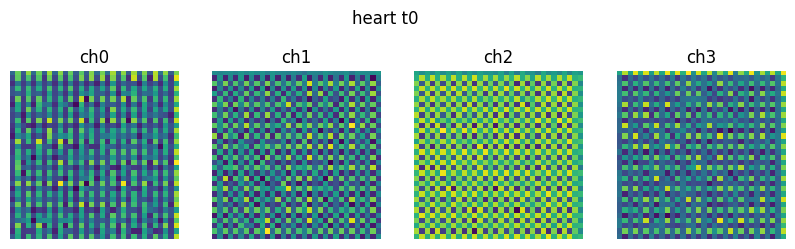


--- heart_t1.png ---


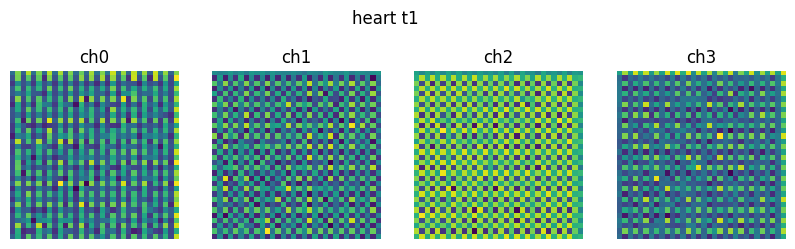


--- heart_t10.png ---


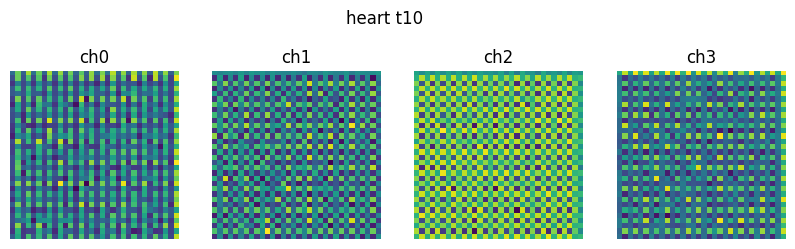


--- heart_t11.png ---


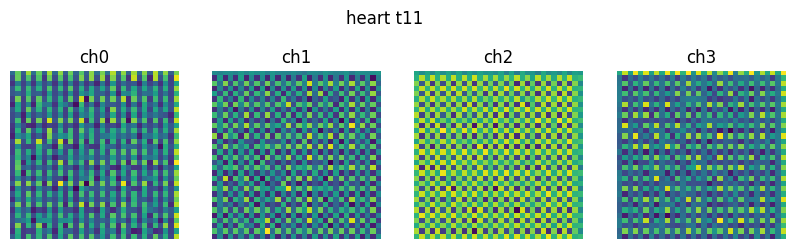


--- heart_t12.png ---


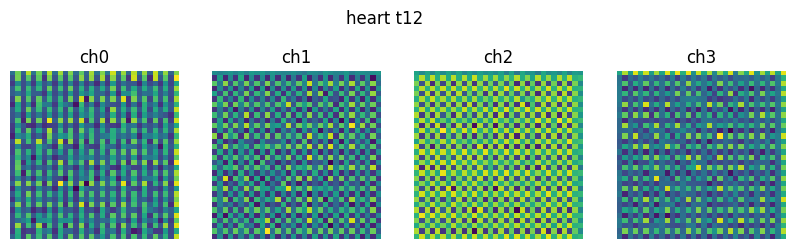


--- heart_t13.png ---


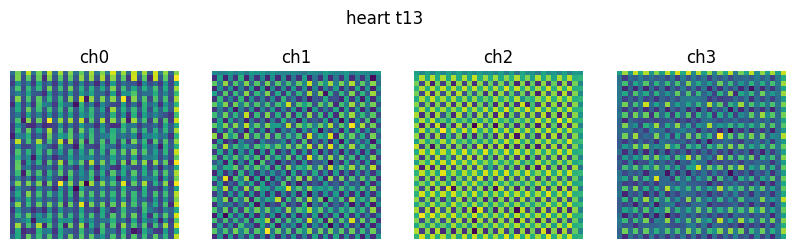


--- heart_t14.png ---


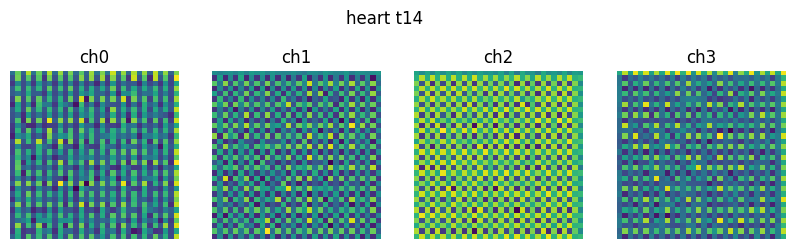


--- heart_t15.png ---


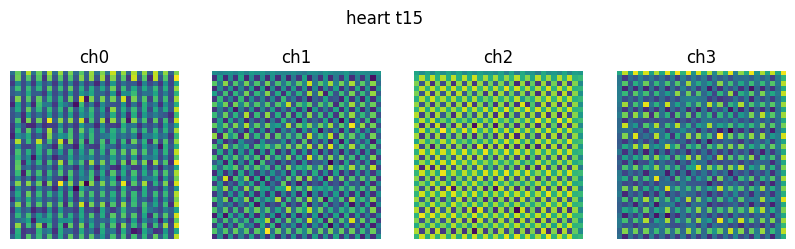


--- heart_t16.png ---


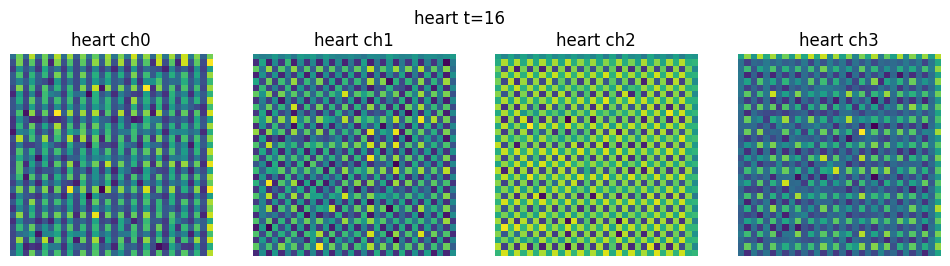


--- heart_t2.png ---


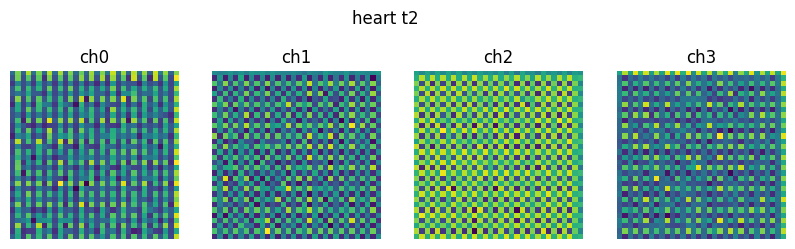


--- heart_t3.png ---


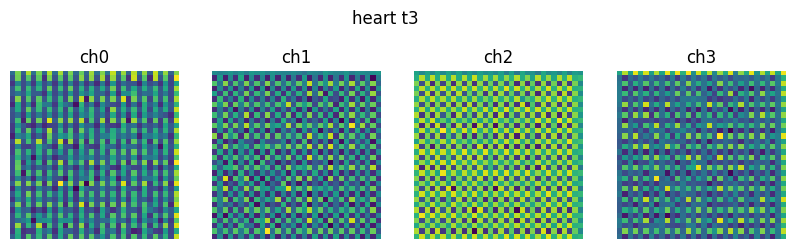


--- heart_t4.png ---


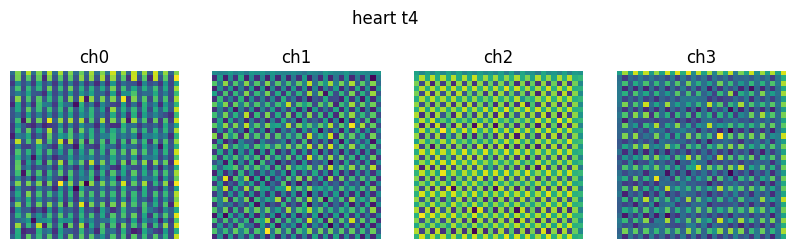


--- heart_t5.png ---


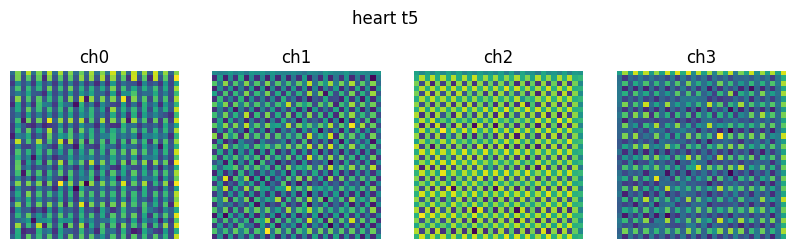


--- heart_t6.png ---


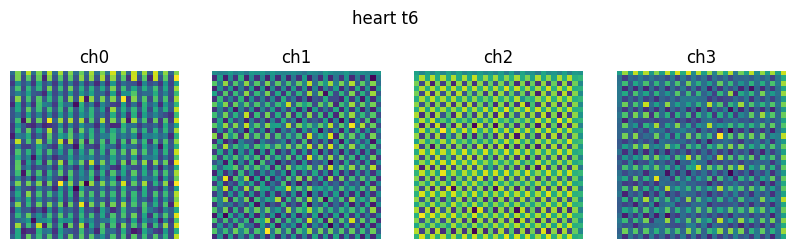


--- heart_t7.png ---


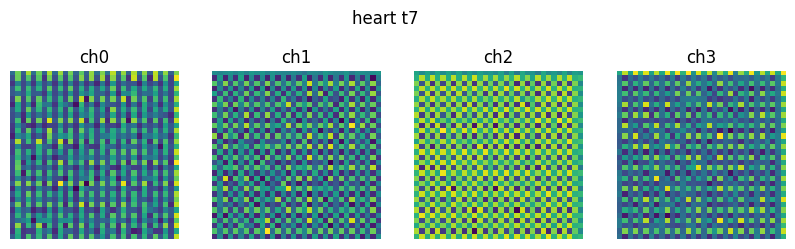


--- heart_t8.png ---


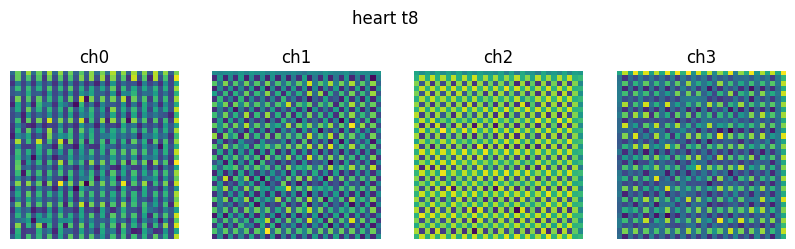


--- heart_t9.png ---


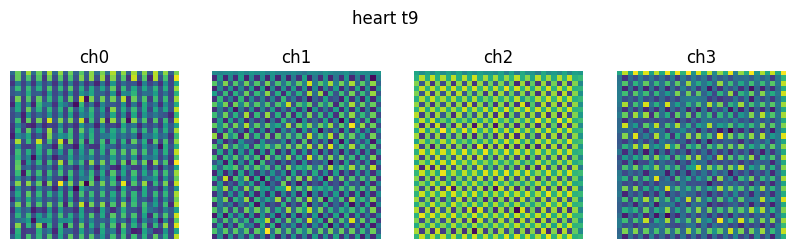


--- kidney_t0.png ---


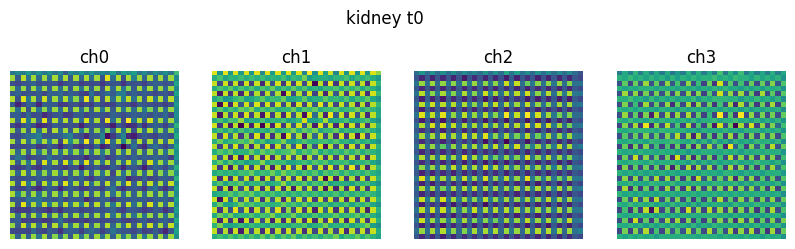


--- kidney_t1.png ---


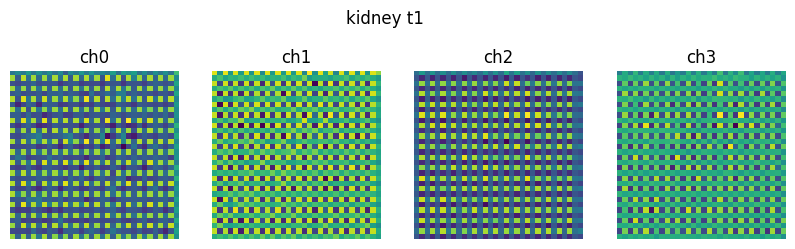


--- kidney_t10.png ---


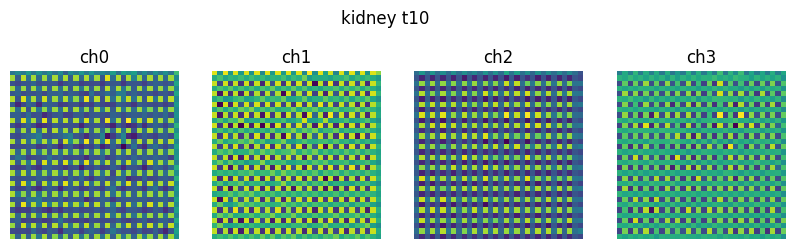


--- kidney_t11.png ---


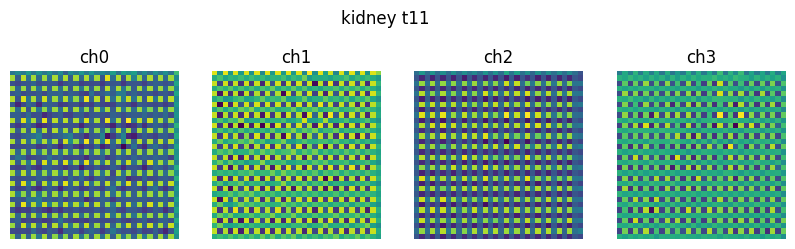


--- kidney_t12.png ---


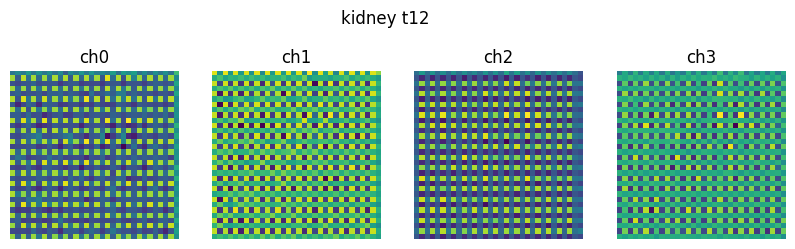


--- kidney_t13.png ---


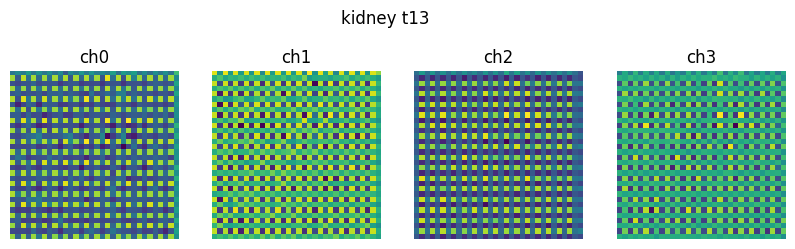


--- kidney_t14.png ---


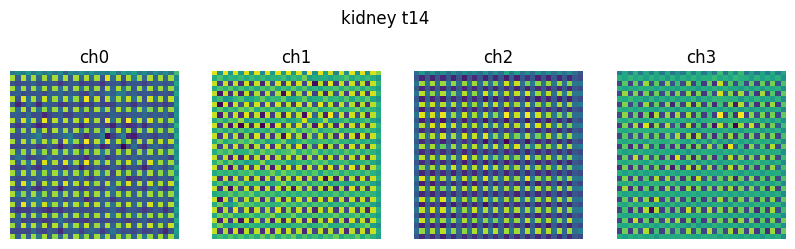


--- kidney_t15.png ---


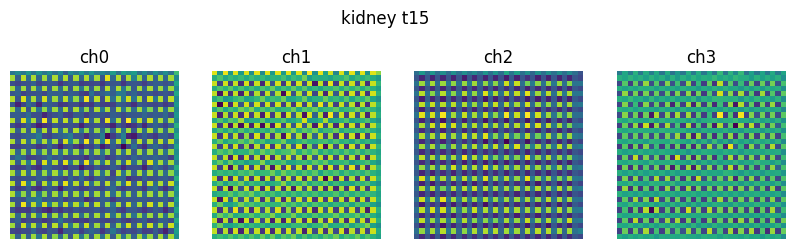


--- kidney_t16.png ---


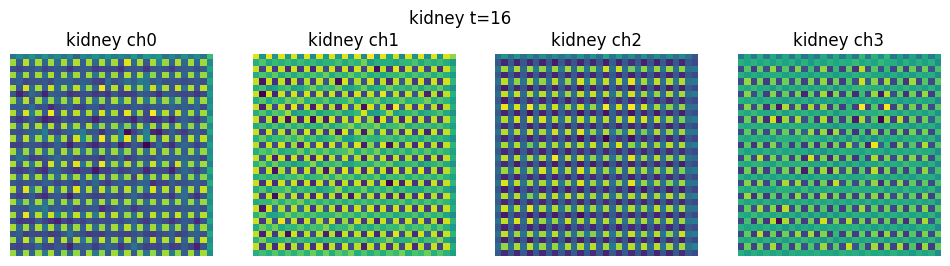


--- kidney_t2.png ---


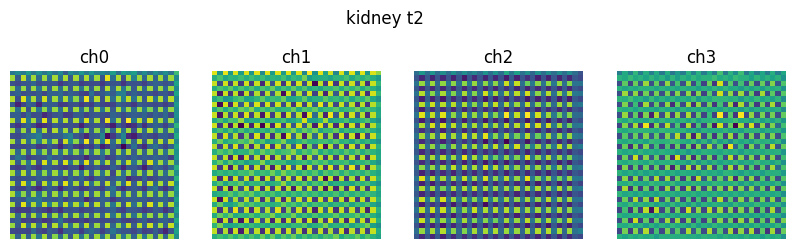


--- kidney_t3.png ---


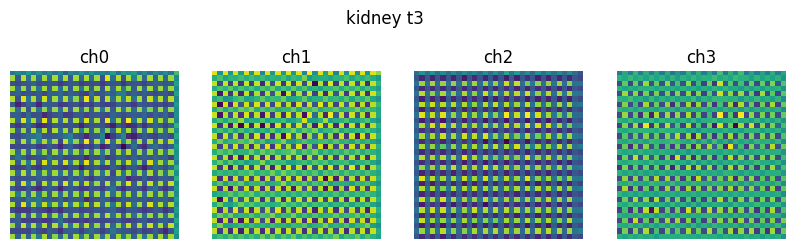


--- kidney_t4.png ---


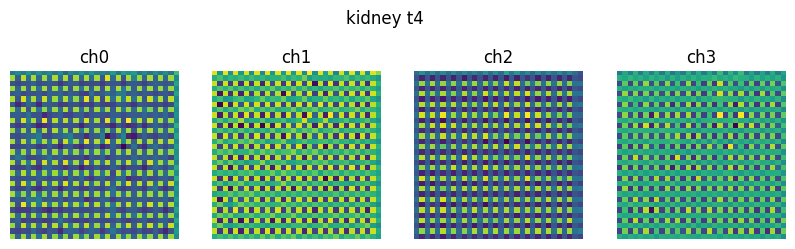


--- kidney_t5.png ---


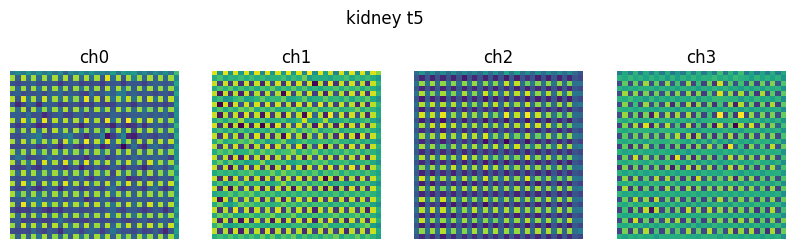


--- kidney_t6.png ---


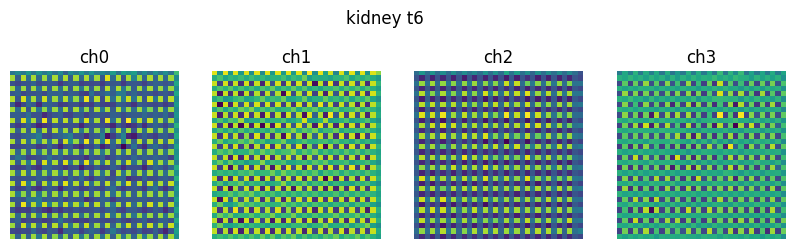


--- kidney_t7.png ---


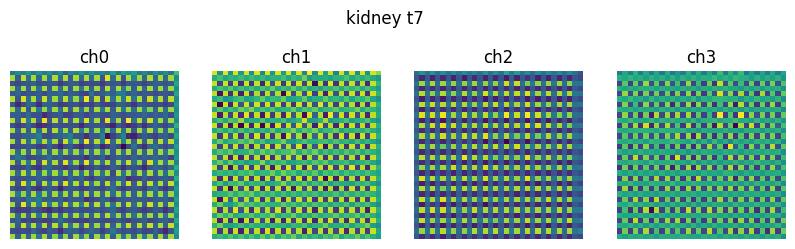


--- kidney_t8.png ---


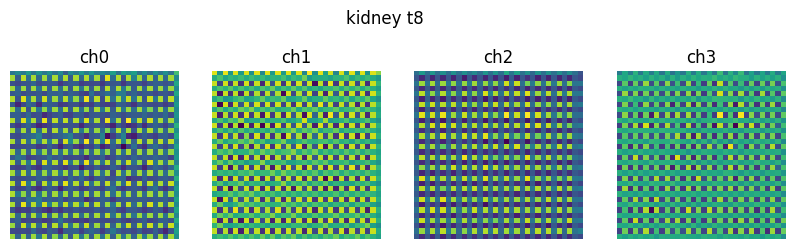


--- kidney_t9.png ---


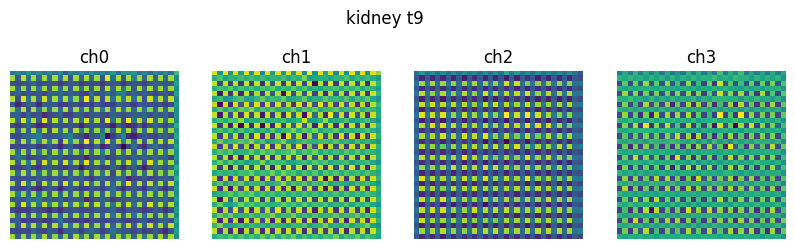


--- liver_t0.png ---


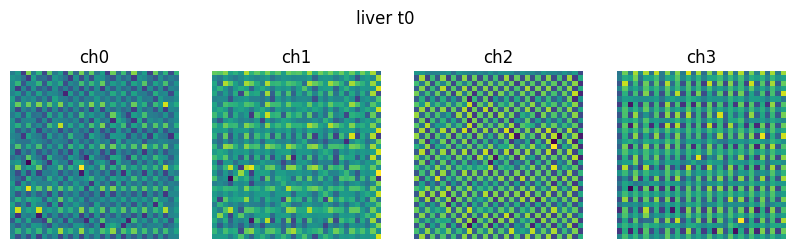


--- liver_t1.png ---


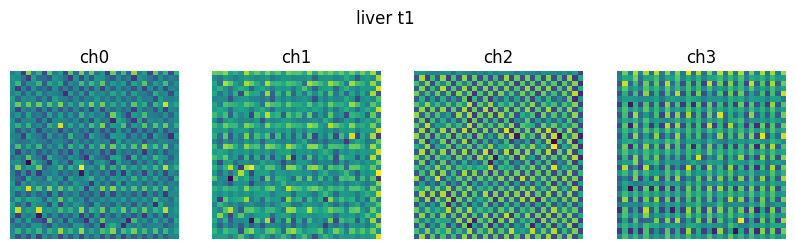


--- liver_t10.png ---


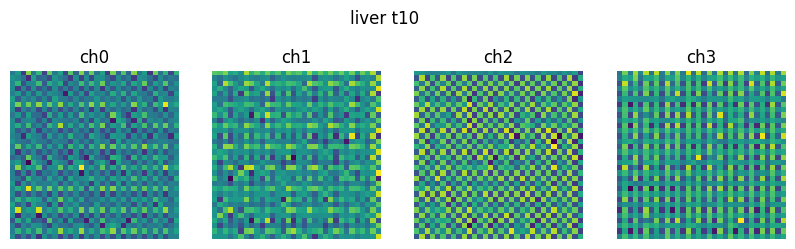


--- liver_t11.png ---


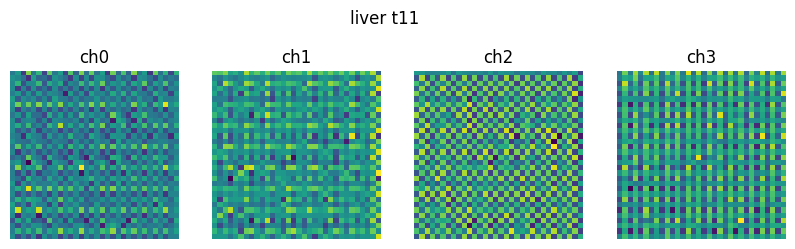


--- liver_t12.png ---


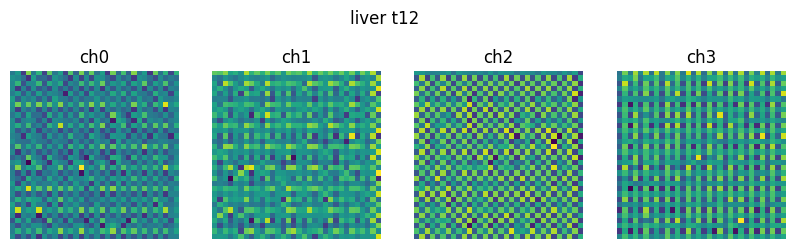


--- liver_t13.png ---


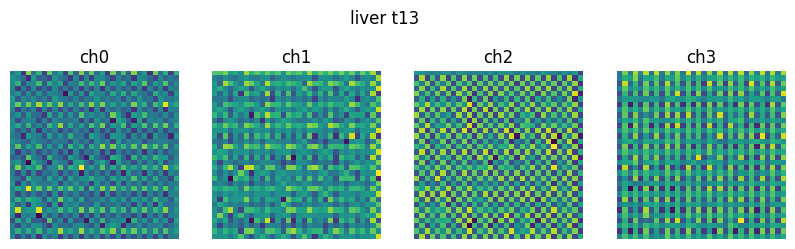


--- liver_t14.png ---


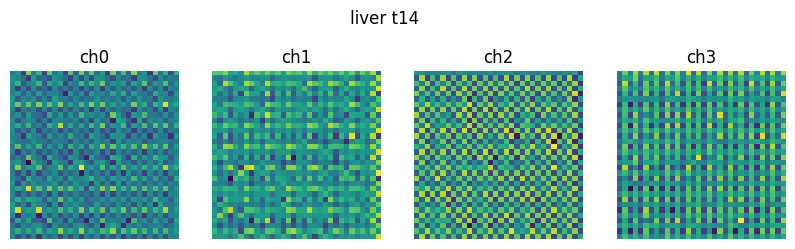


--- liver_t15.png ---


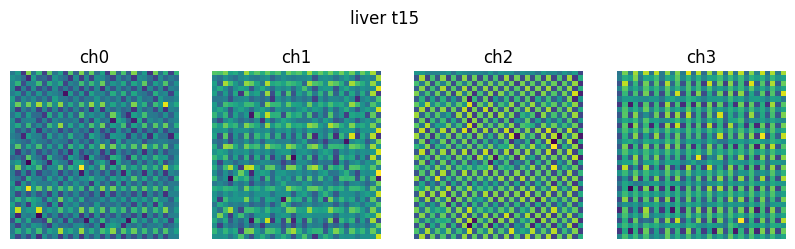


--- liver_t16.png ---


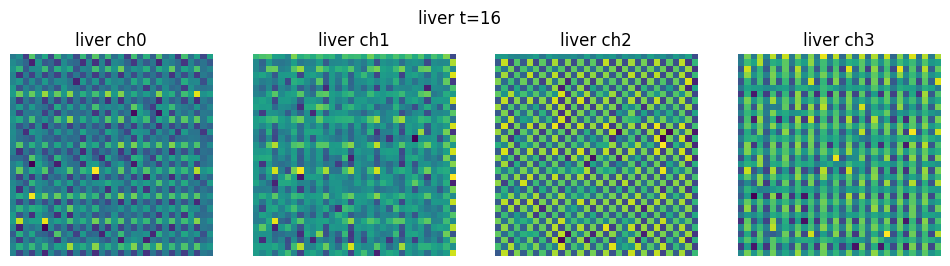


--- liver_t2.png ---


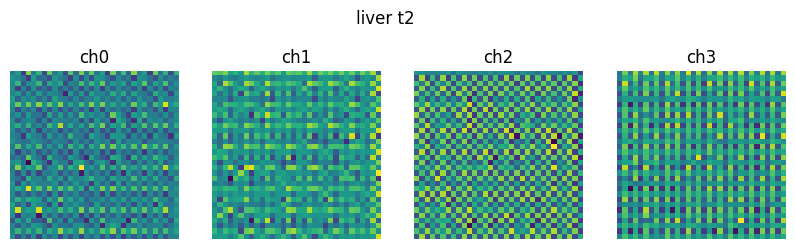


--- liver_t3.png ---


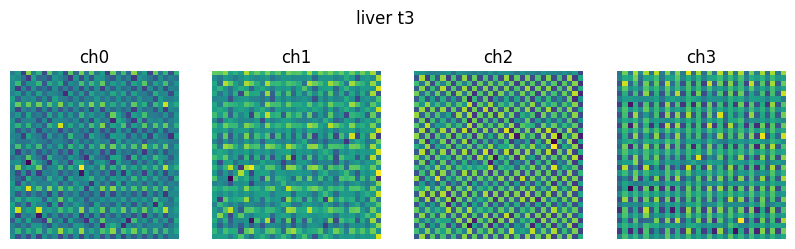


--- liver_t4.png ---


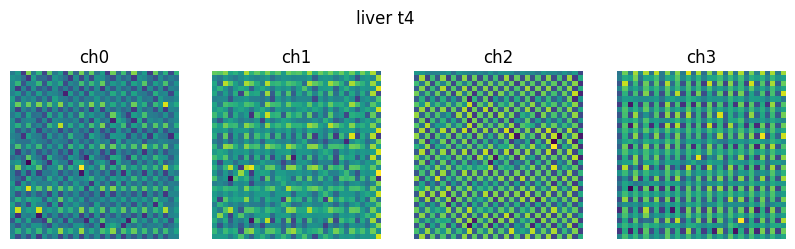


--- liver_t5.png ---


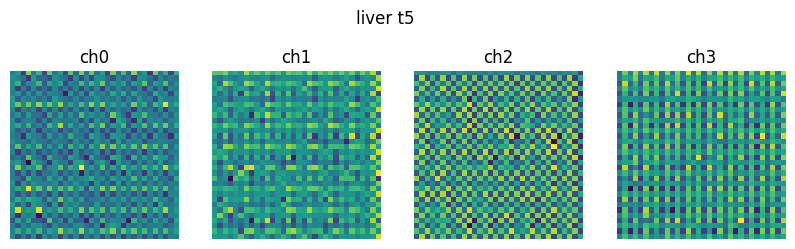


--- liver_t6.png ---


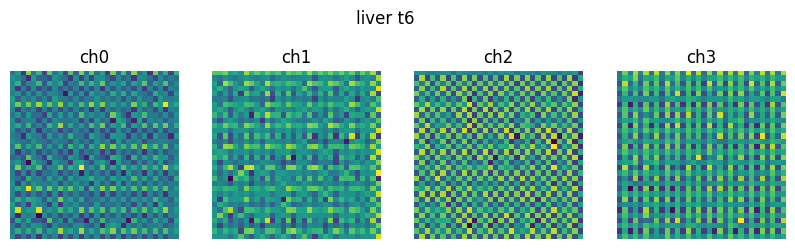


--- liver_t7.png ---


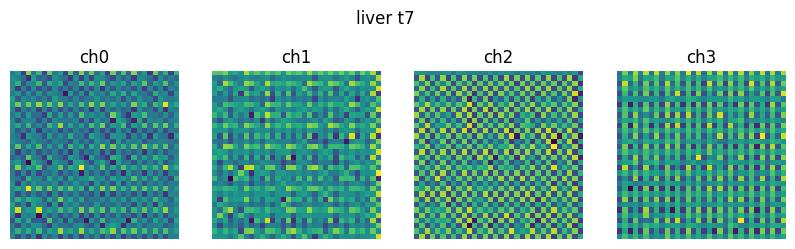


--- liver_t8.png ---


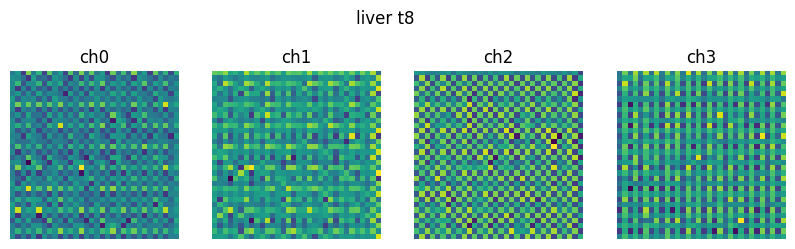


--- liver_t9.png ---


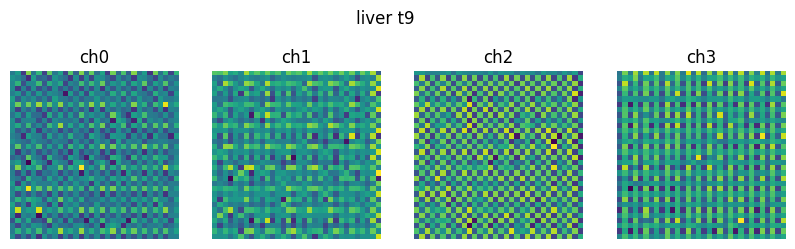

In [ ]:
import os
from IPython.display import Image, display

render_dir = "example_renders"
image_files = sorted([f for f in os.listdir(render_dir) if f.endswith(('.png', '.jpg'))])

if not image_files:
    print(f"No image files found in '{render_dir}'.")
else:
    print(f"Displaying images from '{render_dir}':")
    for img_file in image_files:
        print(f"\n--- {img_file} ---")
        display(Image(filename=os.path.join(render_dir, img_file)))

In [ ]:
!python eval_latents_umap.py

2025-11-18 07:53:49.152391: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763452429.207905   46488 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763452429.225099   46488 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763452429.268797   46488 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763452429.268875   46488 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763452429.268885   46488 computation_placer.cc:177] computation placer alr

In [ ]:
%%writefile eval_latents_umap.py
"""
Evaluate latent structure of pretrained VirtualCellWithConv
Generates:
  - latent_clusters.png (UMAP scatter plot)
  - latents.npy         (latent vectors)
  - features.npy        (input feature vectors)
"""

import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from umap import UMAP
import sys # Import sys
sys.path.append('.') # Add current directory to sys.path

# ----------------------------------------------------------
# Import the model class used during training
# ----------------------------------------------------------
from pretrain_chamber import VirtualCellWithConv

# ----------------------------------------------------------
# Synthetic data generator (same distributions as training)
# ----------------------------------------------------------
def generate_synthetic_cells(n=8000, seed=1):
    rng = np.random.default_rng(seed)
    tel = rng.normal(800.0, 60.0, size=(n,))
    debris = rng.beta(1.2, 8.0, size=(n,))
    div = rng.binomial(1, 0.05, size=(n,))
    tel_act = rng.beta(0.8, 6.0, size=(n,)) * 0.5

    features = np.stack([
        tel / 1000.0,
        debris.astype(np.float32),
        div.astype(np.float32),
        tel_act.astype(np.float32)
    ], axis=1).astype(np.float32)

    return features


# ----------------------------------------------------------
# Load model checkpoint
# ----------------------------------------------------------
def load_model(ckpt_path):
    ckpt = torch.load(ckpt_path, map_location="cpu")
    model = VirtualCellWithConv(input_dim=4, latent_dim=32)
    model.load_state_dict(ckpt["model_state"])
    model.eval()
    return model


# ----------------------------------------------------------
# Extract latent embeddings
# ----------------------------------------------------------
def extract_latents(model, features):
    with torch.no_grad():
        x = torch.tensor(features, dtype=torch.float32)
        _, lat, _ = model(x)
        return lat.cpu().numpy()


# ----------------------------------------------------------
# Plot UMAP scatter
# ----------------------------------------------------------
def plot_umap(latents, features, out="latent_clusters.png"):
    # Normalize before UMAP
    scaler = StandardScaler()
    X = scaler.fit_transform(latents)

    reducer = UMAP(n_components=2, n_neighbors=30, min_dist=0.2, random_state=42)
    emb = reducer.fit_transform(X)

    # Color cells by division state (0 = non-dividing, 1 = dividing)
    div_state = features[:, 2]

    plt.figure(figsize=(8, 6))
    plt.scatter(
        emb[:, 0], emb[:, 1],
        c=div_state,
        cmap="viridis",
        s=8,
        alpha=0.7
    )
    plt.title("UMAP of VirtualCellWithConv Latent Space")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    cbar = plt.colorbar()
    cbar.set_label("Division state (0 = resting, 1 = dividing)")

    plt.tight_layout()
    plt.savefig(out, dpi=300)
    plt.close()
    print(f"[saved] {out}")

    return emb


# ----------------------------------------------------------
# Main
# ----------------------------------------------------------
def main():
    ckpt_path = "./checkpoints/virtualcell_conv.pth"
    Path("eval_outputs").mkdir(exist_ok=True)

    print("[1] Generating synthetic virtual cell data...")
    features = generate_synthetic_cells(n=8000)

    print("[2] Loading pretrained model...")
    model = load_model(ckpt_path)

    print("[3] Extracting latent embeddings...")
    latents = extract_latents(model, features)

    print("[4] Running UMAP and saving visualization...")
    plot_umap(
        latents,
        features,
        out="eval_outputs/latent_clusters.png"
    )

    np.save("eval_outputs/latents.npy", latents)
    np.save("eval_outputs/features.npy", features)

    print("[done] Latent evaluation complete.")
    print("Files written to eval_outputs/:")
    print("  - latent_clusters.png")
    print("  - latents.npy")
    print("  - features.npy")


if __name__ == "__main__":
    main()

Writing eval_latents_umap.py


In [ ]:
%%writefile visualize_3d.py
# visualize_3d.py
"""
3D UMAP and 3D t-SNE visualizations for latent vectors.

Inputs:
  --latents  path to latents.npy (N x D)
  --features path to features.npy (N x F) [expects features[:,2] = division state, features[:,0] = telomere scaled]
Outputs (saved to same folder as latents file):
  - latent_umap_3d.png
  - latent_tsne_3d.png
  - latent_umap_3d.html
  - latent_tsne_3d.html
"""

import argparse
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from sklearn.manifold import TSNE
import umap
import plotly.express as px
import plotly.io as pio

def load_data(latents_path, features_path):
    latents = np.load(latents_path)
    features = np.load(features_path) if features_path is not None else None
    return latents, features

def subsample(X, features=None, max_points=8000, seed=42):
    n = X.shape[0]
    if n <= max_points:
        return X, features, np.arange(n)
    rng = np.random.default_rng(seed)
    idx = rng.choice(n, size=max_points, replace=False)
    Xs = X[idx]
    Fs = features[idx] if features is not None else None
    return Xs, Fs, idx

def run_umap_3d(X, n_neighbors=30, min_dist=0.1, random_state=42):
    reducer = umap.UMAP(n_components=3, n_neighbors=n_neighbors, min_dist=0.1, random_state=random_state)
    emb = reducer.fit_transform(X)
    return emb

def run_tsne_3d(X, perplexity=30, learning_rate=200, random_state=42):
    tsne = TSNE(n_components=3, perplexity=perplexity, learning_rate=learning_rate, init='pca', random_state=random_state)
    emb = tsne.fit_transform(X)
    return emb

def plot_matplotlib_3d(emb, color_vals, out_png, title):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(emb[:,0], emb[:,1], emb[:,2], c=color_vals, cmap='viridis', s=6, alpha=0.8)
    cbar = plt.colorbar(sc, pad=0.1, shrink=0.6)
    cbar.ax.tick_params(labelsize=8)
    ax.set_xlabel('Dim 1'); ax.set_ylabel('Dim 2'); ax.set_zlabel('Dim 3')
    ax.set_title(title)
    plt.tight_layout()
    fig.savefig(out_png, dpi=300)
    plt.close(fig)
    print(f"[saved] {out_png}")

def plot_plotly_3d(emb, color_vals, out_html, title, hover_text=None):
    df = {
        'x': emb[:,0], 'y': emb[:,1], 'z': emb[:,2],
        'color': color_vals
    }
    if hover_text is not None:
        df['hover'] = hover_text
        fig = px.scatter_3d(df, x='x', y='y', z='z', color='color', hover_name='hover', color_continuous_scale='Viridis')
    else:
        fig = px.scatter_3d(df, x='x', y='y', z='z', color='color', color_continuous_scale='Viridis')
    fig.update_layout(title=title, margin=dict(l=0, r=0, b=0, t=30))
    pio.write_html(fig, file=out_html, auto_open=False)
    print(f"[saved interactive] {out_html}")

def main():
    p = argparse.ArgumentParser()
    p.add_argument("--latents", required=True, help="Path to latents.npy")
    p.add_argument("--features", default=None, help="Path to features.npy (optional)")
    p.add_argument("--outdir", default=None, help="Output directory (defaults to latents parent dir)")
    p.add_argument("--color-by", choices=["division", "telomere"], default="division",
                   help="Which feature to color by: 'division' (features[:,2]) or 'telomere' (features[:,0])")
    p.add_argument("--max-points", type=int, default=8000, help="Subsample to this many points for visualization")
    p.add_argument("--run-tsne", action="store_true", help="Also run t-SNE (slow)")
    args = p.parse_args()

    latents_path = Path(args.latents)
    outdir = Path(args.outdir) if args.outdir else latents_path.parent
    outdir.mkdir(parents=True, exist_ok=True)
    latents, features = load_data(str(latents_path), args.features)
    X, F, idx = subsample(latents, features, max_points=args.max_points)

    if F is None:
        # fallback: color by density (norm)
        color_div = np.linalg.norm(X, axis=1)
        tel_vals = color_div
    else:
        if args.color_by == "division":
            color_div = F[:,2]
            tel_vals = F[:,0]
        else:
            color_div = F[:,0]
            tel_vals = F[:,2]

    # UMAP 3D
    print("[umap] computing 3D UMAP (this may take a moment)...")
    umap_emb = run_umap_3d(X, n_neighbors=30, min_dist=0.1)
    umap_png = outdir / "latent_umap_3d.png"
    umap_html = outdir / "latent_umap_3d.html"
    plot_matplotlib_3d(umap_emb, color_div, str(umap_png), "3D UMAP of Latents")
    plot_plotly_3d(umap_emb, color_div, str(umap_html), "3D UMAP of Latents", hover_text=None)

    # t-SNE 3D (optional)
    if args.run_tsne:
        print("[tsne] computing 3D t-SNE (this is slower)...")
        tsne_emb = run_tsne_3d(X, perplexity=50, learning_rate=200)
        tsne_png = outdir / "latent_tsne_3d.png"
        tsne_html = outdir / "latent_tsne_3d.html"
        plot_matplotlib_3d(tsne_emb, color_div, str(tsne_png), "3D t-SNE of Latents")
        plot_plotly_3d(tsne_emb, color_div, str(tsne_html), "3D t-SNE of Latents", hover_text=None)

    # Save embeddings & index mapping
    np.save(outdir / "umap_3d_emb.npy", umap_emb)
    if args.run_tsne:
        np.save(outdir / "tsne_3d_emb.npy", tsne_emb)

    print("[done] outputs written to", outdir)

if __name__ == "__main__":
    main()

Writing visualize_3d.py


In [ ]:
!python visualize_3d.py --latents eval_outputs/latents.npy --features eval_outputs/features.npy --outdir eval_outputs --run-tsne

2025-11-18 07:51:17.167436: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763452277.227571   45891 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763452277.248520   45891 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763452277.294194   45891 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763452277.294283   45891 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763452277.294296   45891 computation_placer.cc:177] computation placer alr

In [ ]:
# param_sweep_telomere_sim.py
"""
Safe abstract telomere-design parameter sweep simulator.

Each "design" is an abstract parameter set:
  - stability: reduces per-division loss fraction (0..1)
  - recognition_affinity: increases probability telomerase acts when signaled (0..1)
  - repair_efficiency: probability of repairing stochastic damage per timestep (0..1)

This script simulates many lineages, returns:
  - mean final telomere length
  - fraction of lineages senesced
  - a cancer-risk proxy (fraction with high divisions AND persistent activation)

No DNA sequences are produced or inferred. Purely numeric, safe simulation.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import os
from tqdm import tqdm

def simulate_lineage(initial_length=1000.0,
                     stability=0.0,
                     recognition_affinity=0.5,
                     repair_efficiency=0.1,
                     base_loss_mean=50.0,
                     base_loss_sd=10.0,
                     max_steps=1000,
                     division_prob=0.05,
                     telomerase_threshold=0.9):
    """
    Simulate one lineage over time. Returns summary dict.
    stability: fraction [0..1] that reduces loss_per_div (higher -> less loss)
    recognition_affinity: probability telomerase engages when controller requests it
    repair_efficiency: per-step probability to repair random damage
    """
    L = initial_length
    age = 0
    telomerase_active = False
    persistent_activation_steps = 0
    divisions = 0
    # controller simplified: ask for telomerase if L < target
    target = initial_length
    for t in range(max_steps):
        # per-step repair of random damage
        if np.random.rand() < repair_efficiency:
            L += 1.0  # small repair increment

        # decide division
        if np.random.rand() < division_prob:
            divisions += 1
            # stochastic base loss
            loss = max(0.0, np.random.normal(base_loss_mean, base_loss_sd))
            # apply stability: less effective loss
            loss = loss * (1.0 - stability)
            L -= loss
            # if controller would request telomerase because L below target
            if L < target:
                # telomerase engages with probability = recognition_affinity
                if np.random.rand() < recognition_affinity:
                    # telomerase adds back a fraction proportional to recognition_affinity
                    L += recognition_affinity * 80.0  # abstract add magnitude
                    telomerase_active = True
                else:
                    telomerase_active = False
            else:
                telomerase_active = False

        # track persistence
        if telomerase_active:
            persistent_activation_steps += 1

        # termination: if too short
        if L <= 200.0:
            # senesced
            return {
                "final_L": L,
                "divisions": divisions,
                "senesced": True,
                "persistent_activation_steps": persistent_activation_steps
            }
    # if reached max_steps without senescing
    return {
        "final_L": L,
        "divisions": divisions,
        "senesced": False,
        "persistent_activation_steps": persistent_activation_steps
    }

def run_sweep(stability_vals, affinity_vals, repair_vals,
              replicates=200, out_dir="param_sweep_results"):
    os.makedirs(out_dir, exist_ok=True)
    rows = []
    total = len(stability_vals) * len(affinity_vals) * len(repair_vals) * replicates
    pbar = tqdm(total=total, desc="Simulating")
    for stability, affinity, repair in itertools.product(stability_vals, affinity_vals, repair_vals):
        acc_finalL = []
        acc_divs = []
        acc_senesced = []
        acc_persistent = []
        for r in range(replicates):
            res = simulate_lineage(stability=stability,
                                   recognition_affinity=affinity,
                                   repair_efficiency=repair)
            acc_finalL.append(res["final_L"])
            acc_divs.append(res["divisions"])
            acc_senesced.append(1 if res["senesced"] else 0)
            acc_persistent.append(res["persistent_activation_steps"])
            pbar.update(1)
        row = {
            "stability": stability,
            "affinity": affinity,
            "repair": repair,
            "mean_final_L": np.mean(acc_finalL),
            "std_final_L": np.std(acc_finalL),
            "mean_divisions": np.mean(acc_divs),
            "frac_senesced": np.mean(acc_senesced),
            "mean_persistent_activation": np.mean(acc_persistent)
        }
        rows.append(row)
    pbar.close()
    df = pd.DataFrame(rows)
    out_csv = os.path.join(out_dir, "param_sweep_summary.csv")
    df.to_csv(out_csv, index=False)
    print(f"Saved summary to {out_csv}")
    return df

def plot_heatmaps(df, out_dir="param_sweep_results"):
    os.makedirs(out_dir, exist_ok=True)
    # pivot for heatmaps: for fixed repair value, plot stability x affinity
    repair_vals = sorted(df["repair"].unique())
    for r in repair_vals:
        sub = df[df["repair"] == r]
        pivot = sub.pivot(index="stability", columns="affinity", values="mean_final_L")
        plt.figure(figsize=(6,5))
        plt.title(f"Mean final L (repair={r})")
        im = plt.imshow(pivot.values, origin="lower", aspect="auto", cmap="viridis")
        plt.yticks(range(len(pivot.index)), ["{:.2f}".format(x) for x in pivot.index])
        plt.xticks(range(len(pivot.columns)), ["{:.2f}".format(x) for x in pivot.columns], rotation=45)
        plt.colorbar(im, label="mean_final_L")
        plt.xlabel("recognition_affinity")
        plt.ylabel("stability")
        plt.tight_layout()
        fname = os.path.join(out_dir, f"heat_finalL_repair{r:.2f}.png")
        plt.savefig(fname, dpi=200)
        plt.close()
        # also plot fraction senesced
        pivot2 = sub.pivot(index="stability", columns="affinity", values="frac_senesced")
        plt.figure(figsize=(6,5))
        plt.title(f"Frac senesced (repair={r})")
        im2 = plt.imshow(pivot2.values, origin="lower", aspect="auto", cmap="magma_r")
        plt.yticks(range(len(pivot2.index)), ["{:.2f}".format(x) for x in pivot2.index])
        plt.xticks(range(len(pivot2.columns)), ["{:.2f}".format(x) for x in pivot2.columns], rotation=45)
        plt.colorbar(im2, label="frac_senesced")
        plt.xlabel("recognition_affinity")
        plt.ylabel("stability")
        plt.tight_layout()
        fname2 = os.path.join(out_dir, f"heat_senesced_repair{r:.2f}.png")
        plt.savefig(fname2, dpi=200)
        plt.close()
    print(f"Saved heatmaps to {out_dir}")

if __name__ == "__main__":
    # example sweep ranges (coarse)
    stability_vals = np.linspace(0.0, 0.8, 5)       # abstract stability factor
    affinity_vals = np.linspace(0.0, 1.0, 6)        # telomerase recognition affinity
    repair_vals = np.linspace(0.0, 0.5, 3)          # repair efficiency
    df = run_sweep(stability_vals, affinity_vals, repair_vals, replicates=400)
    plot_heatmaps(df)
    print(df.head())


Simulating: 100%|██████████| 36000/36000 [01:11<00:00, 505.82it/s]


Saved summary to param_sweep_results/param_sweep_summary.csv


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Saved heatmaps to param_sweep_results
   stability  affinity  repair  mean_final_L  std_final_L  mean_divisions  \
0        0.0       0.0    0.00    173.476028    17.035663         16.5500   
1        0.0       0.0    0.25    176.016688    14.379584         18.3150   
2        0.0       0.0    0.50    178.331941    13.560371         20.4750   
3        0.0       0.2    0.00    175.561747    16.224511         17.5875   
4        0.0       0.2    0.25    176.017619    15.358219         19.6900   

   frac_senesced  mean_persistent_activation  
0            1.0                       0.000  
1            1.0                       0.000  
2            1.0                       0.000  
3            1.0                      65.845  
4            1.0                      74.480  


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
%%writefile large_scale_telomere_param_explore.py
"""
Safe large-scale in-silico exploration of abstract telomere "design" parameter space.
NO DNA sequences are generated or implied — each design is an abstract numeric vector.

Outputs:
  - results/summary.csv              : per-design summary metrics
  - results/umap_emb.npy             : 2D UMAP embedding of designs
  - results/clusters.npy             : cluster labels per design
  - results/feature_importances.png  : surrogate model feature importances
  - results/surrogate_model.joblib   : trained RandomForest surrogate
  - results/heatmaps/                : heatmaps for top clusters (optional)

Usage:
  pip install numpy pandas matplotlib scikit-learn umap-learn joblib tqdm seaborn
  python large_scale_telomere_param_explore.py --n_designs 50000 --reps 200 --out results
"""

import argparse
import os
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import umap
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
import sys # Import sys

sns.set(style="whitegrid")

# -------------------------
# Simulation core (abstract)
# -------------------------
def simulate_lineage_abstract(initial_length=1000.0,
                              stability=0.0,
                              recognition_affinity=0.5,
                              repair_efficiency=0.1,
                              structural_propensity=0.5,
                              base_loss_mean=50.0,
                              base_loss_sd=10.0,
                              max_steps=1000,
                              division_prob=0.05,
                              telomerase_threshold_ratio=0.95):
    """
    Simulate one lineage under an abstract 'design' described by numeric features.
    Returns dictionary with metrics.
    Notes: all quantities are numeric, conceptual, and have no mapping to real DNA.
    """
    L = initial_length
    divisions = 0
    persistent_activation = 0
    telomerase_active = False
    # controller threshold (depends partly on recognition_affinity)
    target = initial_length * telomerase_threshold_ratio

    for t in range(max_steps):
        # random repair: increases L occasionally, scaled by repair_efficiency
        if np.random.rand() < repair_efficiency:
            L += np.random.uniform(0.5, 2.0) * repair_efficiency

        # division decision
        if np.random.rand() < division_prob:
            divisions += 1
            # base loss
            loss = max(0.0, np.random.normal(base_loss_mean * (1.0 - 0.2*structural_propensity),
                                            base_loss_sd))
            # stability reduces loss multiplicatively
            loss *= (1.0 - stability)
            L -= loss

            # if below controller target, attempt telomerase extension
            if L < target:
                # probability of successful telomerase engagement = recognition_affinity * function(structural_propensity)
                engage_prob = recognition_affinity * (0.5 + 0.5 * structural_propensity)
                if np.random.rand() < engage_prob:
                    # telomerase adds back an amount proportional to recognition_affinity and structural_propensity
                    add = recognition_affinity * (50.0 + 50.0 * structural_propensity)
                    L += add
                    telomerase_active = True
                else:
                    telomerase_active = False
            else:
                telomerase_active = False

        if telomerase_active:
            persistent_activation += 1

        # stochastic small damage events (scaled by (1-structural_propensity))
        if np.random.rand() < 0.001 + 0.01*(1.0 - structural_propensity):
            L -= np.random.uniform(0.5, 3.0)

        if L <= 200.0:
            # senesced
            return {"final_L": L,
                    "divisions": divisions,
                    "senesced": 1,
                    "persistent_activation": persistent_activation}
    return {"final_L": L,
            "divisions": divisions,
            "senesced": 0,
            "persistent_activation": persistent_activation}

# -------------------------
# Per-design simulation wrapper
# -------------------------
def evaluate_design(design_params, reps=200, seed_base=0):
    """
    design_params: dict with keys:
       - stability [0..1]
       - recognition_affinity [0..1]
       - repair_efficiency [0..1]
       - structural_propensity [0..1]
    Returns aggregated metrics across 'reps' stochastic replicate lineages.
    """
    rng = np.random.default_rng(seed_base)
    finals = []
    divs = []
    senesced_flags = []
    pers_acts = []
    for r in range(reps):
        res = simulate_lineage_abstract(
            stability=design_params["stability"],
            recognition_affinity=design_params["recognition_affinity"],
            repair_efficiency=design_params["repair_efficiency"],
            structural_propensity=design_params["structural_propensity"],
            max_steps=1000,
            division_prob=0.05
        )
        finals.append(res["final_L"])
        divs.append(res["divisions"])
        senesced_flags.append(res["senesced"])
        pers_acts.append(res["persistent_activation"])
    finals = np.array(finals)
    divs = np.array(divs)
    senesced_flags = np.array(senesced_flags)
    pers_acts = np.array(pers_acts)

    # compute metrics
    metrics = {
        "mean_final_L": finals.mean(),
        "median_final_L": np.median(finals),
        "std_final_L": finals.std(),
        "mean_divisions": divs.mean(),
        "frac_senesced": senesced_flags.mean(),
        "mean_persistent_activation": pers_acts.mean()
    }
    return metrics

# -------------------------
# Sampling of designs
# -------------------------
def sample_designs(n_designs, seed=0, strategy="uniform"):
    rng = np.random.default_rng(seed)
    if strategy == "uniform":
        designs = pd.DataFrame({
            "stability": rng.uniform(0.0, 1.0, size=n_designs),
            "recognition_affinity": rng.uniform(0.0, 1.0, size=n_designs),
            "repair_efficiency": rng.uniform(0.0, 1.0, size=n_designs),
            "structural_propensity": rng.uniform(0.0, 1.0, size=n_designs)
        })
    elif strategy == "lhs":
        # simple Latin-hypercube style sampling via sorting trick per-dim
        designs = {}
        for name in ["stability","recognition_affinity","repair_efficiency","structural_propensity"]:
            u = rng.uniform(size=n_designs)
            ranks = np.argsort(np.argsort(u))
            designs[name] = (ranks + rng.uniform(size=n_designs)) / n_designs
        designs = pd.DataFrame(designs)
    else:
        raise ValueError("unknown sampling strategy")
    return designs

# -------------------------
# Top-level runner
# -------------------------
def run_large_explore(n_designs=50000, reps=200, out="results", seed=0, n_jobs=1):
    outdir = Path(out)
    outdir.mkdir(parents=True, exist_ok=True)
    heat_dir = outdir / "heatmaps"
    heat_dir.mkdir(exist_ok=True)

    print(f"[run] sampling {n_designs} designs (seed={seed})")
    designs = sample_designs(n_designs, seed=seed, strategy="uniform")
    results_rows = []
    pbar = tqdm(total=n_designs, desc="designs")

    # Evaluate designs in batches to control memory/time
    for i, row in designs.iterrows():
        params = row.to_dict()
        metrics = evaluate_design(params, reps=reps, seed_base=seed + int(i))
        results_rows.append({**params, **metrics})
        pbar.update(1)
    pbar.close()
    df = pd.DataFrame(results_rows)
    summary_csv = outdir / "summary.csv"
    df.to_csv(summary_csv, index=False)
    print(f"[saved] summary -> {summary_csv}")

    # Build surrogate model to predict mean_final_L from design params
    X = df[["stability","recognition_affinity","repair_efficiency","structural_propensity"]].values
    y = df["mean_final_L"].values
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    rf = RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=seed)
    rf.fit(Xs, y)
    preds = rf.predict(Xs)
    r2 = r2_score(y, preds)
    print(f"[surrogate] RandomForest R^2 on training data: {r2:.4f}")
    joblib.dump({"scaler": scaler, "model": rf}, outdir / "surrogate_model.joblib")

    # Feature importances
    importances = rf.feature_importances_
    fig, ax = plt.subplots(figsize=(6,3))
    sns.barplot(x=["stability","recognition_affinity","repair_efficiency","structural_propensity"],
                y=importances, ax=ax)
    ax.set_ylabel("importance")
    ax.set_title("Surrogate model feature importances")
    fig.savefig(outdir / "feature_importances.png", dpi=200)
    plt.close(fig)

    # UMAP for visualization (2D)
    reducer = umap.UMAP(n_components=2, random_state=seed)
    emb2 = reducer.fit_transform(Xs)
    np.save(outdir / "umap_emb.npy", emb2)
    # cluster in embedding space
    kmeans = KMeans(n_clusters=6, random_state=seed).fit(emb2)
    clusters = kmeans.labels_
    np.save(outdir / "clusters.npy", clusters)

    # add embedding and cluster to df and save
    df["umap1"] = emb2[:,0]
    df["umap2"] = emb2[:,1]
    df["cluster"] = clusters
    df.to_csv(outdir / "summary_with_emb.csv", index=False)

    # Plot UMAP colored by mean_final_L and cluster
    plt.figure(figsize=(6,5))
    sc = plt.scatter(emb2[:,0], emb2[:,1], c=df["mean_final_L"].values, s=6, cmap="viridis", alpha=0.8)
    plt.colorbar(sc, label="mean_final_L")
    plt.title("UMAP of designs colored by mean_final_L")
    plt.tight_layout()
    plt.savefig(outdir / "umap_mean_finalL.png", dpi=200)
    plt.close()

    plt.figure(figsize=(6,5))
    sc = plt.scatter(emb2[:,0], emb2[:,1], c=clusters, s=6, cmap="tab10", alpha=0.8)
    plt.title("UMAP of designs colored by cluster")
    plt.tight_layout()
    plt.savefig(outdir / "umap_clusters.png", dpi=200)
    plt.close()

    print(f"[done] results written to {outdir}")
    return df, rf, scaler

# -------------------------
# CLI
# -------------------------
if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--n_designs", type=int, default=20000, help="Number of abstract designs to sample")
    parser.add_argument("--reps", type=int, default=150, help="Replicates per design (stochastic lineages)")
    parser.add_argument("--out", type=str, default="results", help="Output directory")
    parser.add_argument("--seed", type=int, default=0)

    # Only parse known arguments when running in a Jupyter/Colab notebook
    # This prevents the 'unrecognized arguments' error from '-f' etc.
    if '-f' in sys.argv:
        # When running in Jupyter/Colab, parse an empty list of arguments
        # to prevent argparse from trying to parse kernel-specific args
        args = parser.parse_args([])
    else:
        # Otherwise, parse arguments normally (e.g., when run from command line)
        args = parser.parse_args(sys.argv[1:])

    # Basic resource check warning
    if args.n_designs * args.reps > 5e6:
        print("[warning] Very large runs may be slow. Consider reducing n_designs or reps or run in a compute cluster.")

    df, rf, scaler = run_large_explore(n_designs=args.n_designs, reps=args.reps, out=args.out, seed=args.seed)

Writing large_scale_telomere_param_explore.py
